# **Advanced Lane Finding** 
***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Functions required for this project


In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image    
    
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#Undistort Image
def UndistortImage(img,mtx,dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#Perspective Transform eye-bird
def four_point_transform(image, src):
    # Compute the perspective transform matrix and then apply it
    img_size = (image.shape[1],image.shape[0]) #(w,h)
    offset = img_size[0]*0.25 # shirking image based on width ratio

    #tl, tr, br, bl
    dst = np.array([(offset, 0), (img_size[0]-offset, 0), (img_size[0]-offset, img_size[1]),(offset, img_size[1])], dtype = "float32")   
    #print(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src) #src
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]),flags=cv2.INTER_LINEAR)
 
    # return the warped image
    return Minv, warped

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        self.left_fit = []
        self.right_fit = []
        self.frame = 0



class tracker():
    def __init__(self,window_width,window_height,margin,ym=1,xm= 1,smooth_factor= 15):
        
        self.recent_centers =[]
        self.windows_width=window_width
        self.window_height = window_height
        self.margin = margin
        self.ym_per_pix = ym
        self.xm_per_pix = xm
        self.smooth_factor = smooth_factor


    def find_window_centroids(self,warped):

        #First Method
        binary_warped = warped
        
        default_width_lx = 450
        default_width_rx = 900

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)#np.stack((binary_warped*255, binary_warped*255, binary_warped*255),axis=-1)
        #print(out_img.shape)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        #detecting LeftX and RightX
        midpoint = np.int(histogram.shape[0]/2) #np.int(histogram.shape[0]/2)

        x_border = np.int(3*histogram.shape[0]/4) 
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 50
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        '''self.recent_centers.append((left_lane_inds,right_lane_inds))
        lane_inds_ave = np.average(self.recent_centers[-self.smooth_factor:],axis = 0)
        left_lane_inds = lane_inds_ave[0]
        right_lane_inds = lane_inds_ave[1]
        '''
        return left_lane_inds,right_lane_inds#left_fit, right_fit
    
       # Add what we found for that layer
        #self.recent_centers.append((left_lane_inds,right_lane_inds))
        #return np.average(self.recent_centers[-self.smooth_factor:],axis = 0)
        

## Camera matrix and distortion coefficients

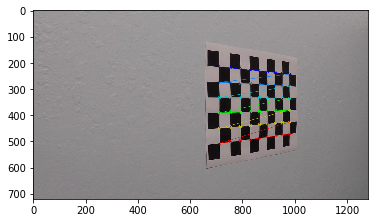

In [4]:
#Finding Corners
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# Make a list of calibration images
import glob #read all calibration images by using glob API
images = glob.glob('camera_cal/calibration*.jpg')


#Distortion Calibration

# Arrays to store object points and images points from all image
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0)...(8,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinates

for fname in images:
    #fname = 'camera_cal/calibration12.jpg'
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp) 
        imgpoints.append(corners) 
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

In [5]:
# Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

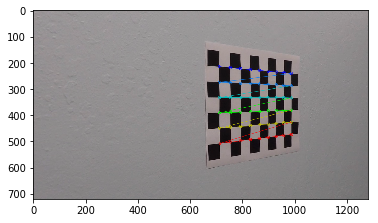

In [6]:
#Undistorting a test image
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

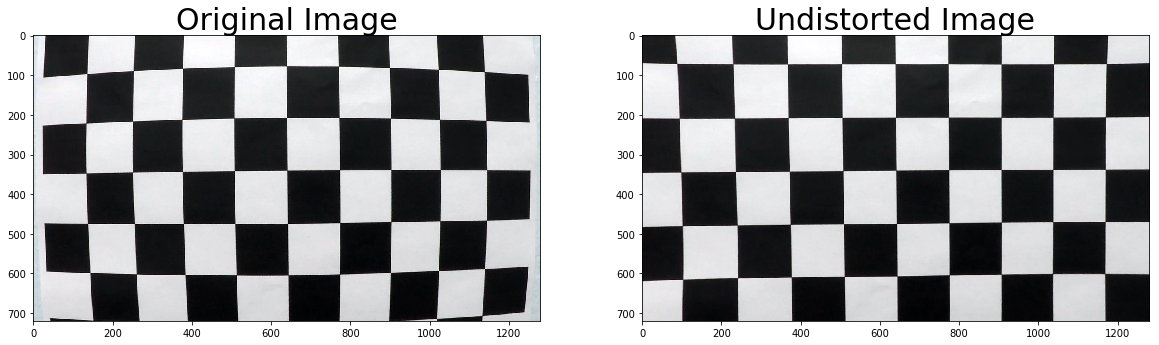

In [7]:
import pickle

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_result/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

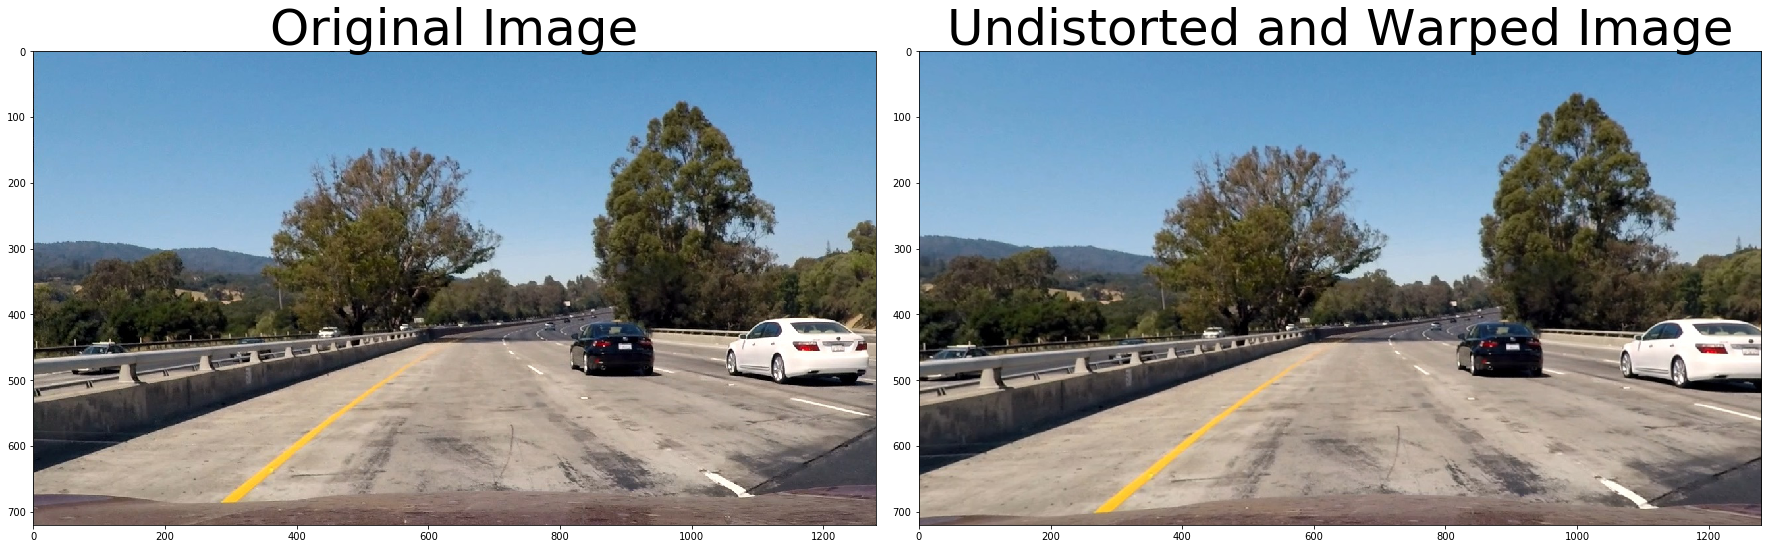

In [8]:
#Perspective Transform

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration_result/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
# Combining Thresholds
# Read in an image
img = mpimg.imread('test_images/test1.jpg')

img_undist = UndistortImage(img,mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
#Color transforms, gradients or other methods to create a thresholded binary image
def binary_image(image, ksize):
    blur_image = gaussian_blur(image,ksize)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(blur_image, orient='x', sobel_kernel=ksize, thresh=(30, 160)) #20,100
    grady = abs_sobel_thresh(blur_image, orient='y', sobel_kernel=ksize, thresh=(10, 255))#30,90
    mag_binary = mag_thresh(blur_image, sobel_kernel=ksize, mag_thresh=(50, 180))#90,160
    dir_binary = dir_threshold(blur_image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(blur_image, thresh=(140, 255)) #180, 255   

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    
    #Morphological Transformations (Improve quality of the line)
    #(http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)
    kernel = np.ones((5,5),np.uint8)
    combined_morph = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    
    return combined_morph

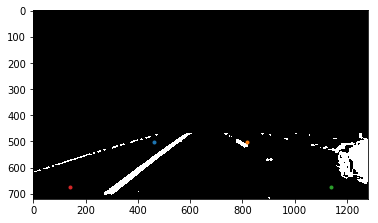

In [10]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration_result/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
# Combining Thresholds
# Read in an image
img = mpimg.imread('frames/pv_resultantImage_18.jpg')

undist = UndistortImage(img,mtx,dist) #Required to project those lines onto the original image
image = UndistortImage(img,mtx,dist)

# Choose a Sobel kernel size and Gaussian smoothing
ksize = 15 # Choose a larger odd number to smooth gradient measurements

#Color, thersholding and Binary Image
image = binary_image(image,ksize)

#Save image
#img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #option 1
#cv2.imwrite("output_images/binary_image.png",image) #option 1
#mpimg.imsave("output_images/binary_image.png",image,format="png",cmap='Greys_r') #option 2


# Defining perspective transformation area
imshape = image.shape
imshape_max_x = imshape[1]
imshape_max_y = imshape[0]

mid_width = .28 # % of middle trapizoid height
bot_width = .78 # % of bottom trapizoid height
height_pct = .70 # % for trapizoid height
bottom_trim = .935 # % from top to bottom to avoid car hood

tl = (imshape_max_x * (.5-mid_width/2), imshape_max_y*height_pct)
tr = (imshape_max_x * (.5+mid_width/2), imshape_max_y*height_pct) 
br = (imshape_max_x * (.5+bot_width/2),imshape_max_y*bottom_trim)
bl = (imshape_max_x * (.5-bot_width/2),imshape_max_y*bottom_trim)

plt.plot(tl[0],tl[1],".") #top left
plt.plot(tr[0],tr[1],".") #top right
plt.plot(br[0],br[1],".") #bottom right
plt.plot(bl[0],bl[1],".") #bottom left

src = np.array([tl, tr, br, bl], dtype = "float32")

#print(src)

#Region of Interest
# This time we are defining a four sided polygon to mask
vertices = np.array([[(0, int(2*imshape_max_y/3)-10),(imshape_max_x, (int(2*imshape_max_y/3)-10)), (imshape_max_x,imshape_max_y), (0,imshape_max_y)]], dtype=np.int32)
image = region_of_interest(image, vertices)
plt.imshow(image, cmap='gray')

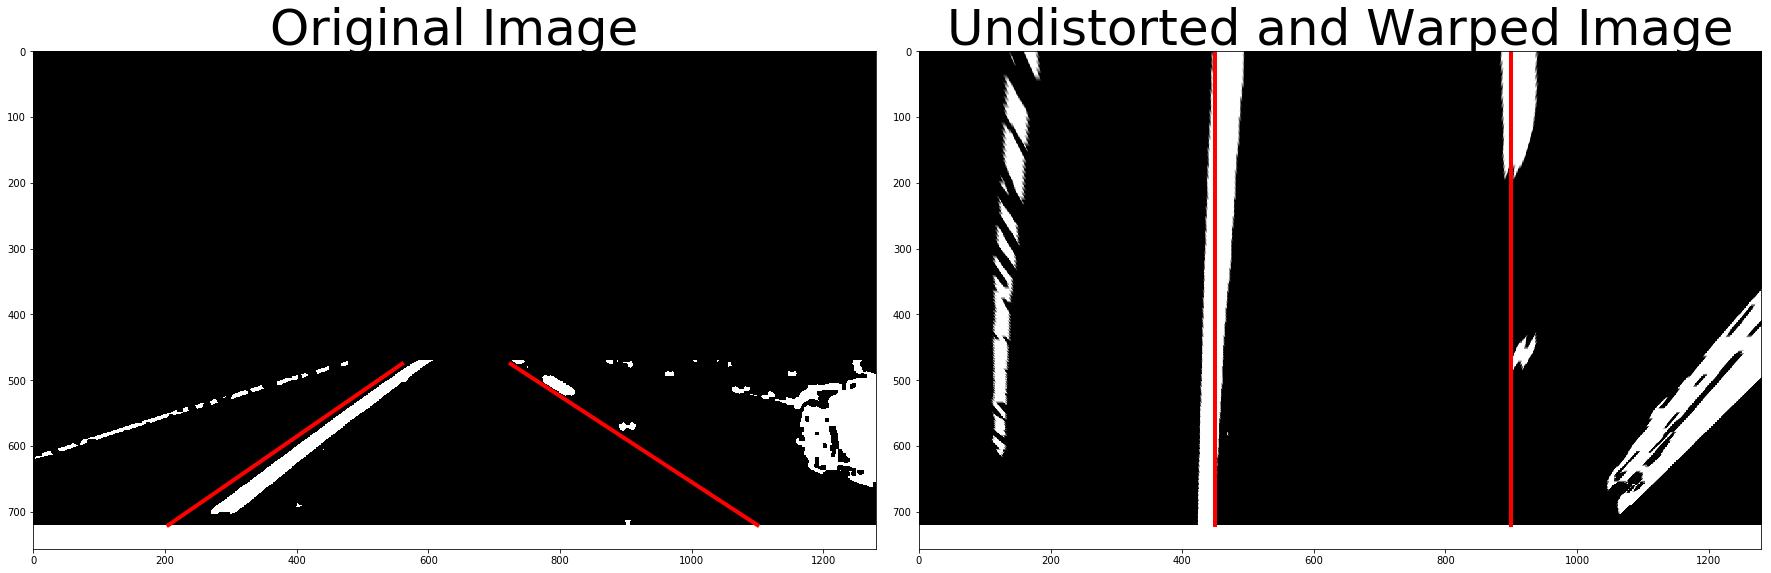

In [11]:
# Apply the four point tranform to obtain a "birds eye view" of the image
Minv, warped = four_point_transform(image, src) #pts

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.imshow(image, cmap='gray')
ax1.plot([560,205], [475,720], linewidth=4.0, color='r') #top left
ax1.plot([725,1100], [475,720], linewidth=4.0, color='r') #top left
ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.imshow(warped, cmap='gray')
ax2.plot([450,450], [0,720], linewidth=4.0, color='r') #top left
ax2.plot([900,900], [0,720], linewidth=4.0, color='r') #top left
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [12]:
binary_warped = warped
print(image.shape)
print(warped.shape)


(720, 1280)
(720, 1280)


In [13]:
#First Method
binary_warped = warped

default_width_lx = 450
default_width_rx = 900

histogram = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,:], axis=0)
out_img = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)#np.stack((binary_warped*255, binary_warped*255, binary_warped*255),axis=-1)
midpoint = np.int(histogram.shape[0]/2) #np.int(histogram.shape[0]/2)

x_border = np.int(3*histogram.shape[0]/4) 
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#Max road width
if (rightx_base >= 1000):
    rightx_base = 1000
    binary_warped[binary_warped.shape[0]-30:binary_warped.shape[0],default_width_rx-15:default_width_rx+15] = 1 #y,x
    binary_warped[0:binary_warped.shape[0],1050:binary_warped.shape[1]] = 0 
    print("Max width")

#ratio right/left lanes
ratio_rl = histogram[rightx_base]/histogram[leftx_base]
print(histogram[rightx_base]/histogram[leftx_base])

#Sync with first row
if (rightx_base <= 850 and ratio_rl <= 0.22):
    rightx_base = default_width_rx
    binary_warped[binary_warped.shape[0]-30:binary_warped.shape[0],default_width_rx-15:default_width_rx+15] = 1 #y,x
    print("sync Bottom")

top_dummy_pixel = binary_warped[0:binary_warped.shape[0]+30,default_width_rx-15:default_width_rx+15]    
total_top_dummy_pixel = np.int(np.sum(top_dummy_pixel))

if total_top_dummy_pixel <= 50:
    binary_warped[0:30,default_width_rx-15:default_width_rx+15]  = 1
    print("sync Top")        

curve_center = tracker(window_width = 3,window_height = 4,margin = 7,ym=10/720,xm= 4/384,smooth_factor= 15)

#Calling Class
lane = Line()
lane.frame = lane.frame + 1

left_lane_inds = 0
right_lane_inds = 0
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

print(lane.detected)
if (lane.detected == False or lane.frame == 30):
    curve_center = tracker(window_width = 3,window_height = 4,margin = 7,ym=10/720,xm= 4/384,smooth_factor= 15)
    left_lane_inds, right_lane_inds = curve_center.find_window_centroids(binary_warped )
    print(left_lane_inds)
    lane.detected = True
    lane.frame = 0
    print("Synchronizing!!!")
else:
    #From previous frame lane_detected)
    left_fit =  lane.left_fit
    right_fit = lane.right_fit
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    print("System Engage")

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

#When right line is not detected repeat the process to find lines
if rightx.shape[0] <= 1000:
    lane.detected = False


# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
#Save new xxx_fit values
lane.left_fit = left_fit  
lane.right_fit = right_fit

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]  

Max width
0.0
False
[50189 50190 50191 ..., 10129 10130 10131]
Synchronizing!!!


(720, 0)

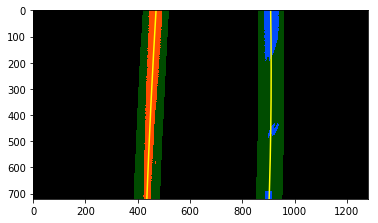

In [15]:
#Visualize 
# Create an image to draw on and an image to show the selection window
margin = 50
out_img = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)#np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

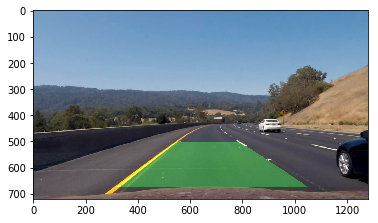

In [16]:
# project those lines onto the original image
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

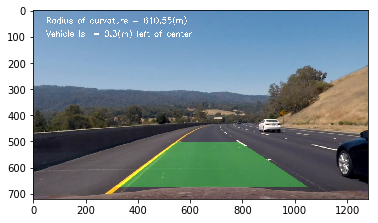

In [17]:
# display metrics in the image 
ym_per_pix = curve_center.ym_per_pix # meters per pixel in y dimension
xm_per_pix = curve_center.xm_per_pix # meters per pixel in x dimension

# Define y-value where we want radius of curvature
res_yvals = lefty
yvals = range(0,warped.shape[0])
curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
curverad =((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/ np.absolute(2*curve_fit_cr[0])

camera_center= (left_fitx[-1] + right_fitx[-1])/2
center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
side_pos = 'left'
if center_diff<=0:
    side_pos = 'right'

cv2.putText(result,"Radius of curvature = "+str(round(curverad,3))+"(m)",(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
cv2.putText(result,"Vehicle is  = "+str(abs(round(center_diff,3)))+"(m) "+side_pos+' of center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

#Save image
#img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
#cv2.imwrite("output_images/final_output.png",img)


plt.imshow(result)

## Test on Videos

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle

In [19]:

    
def process_image(image2):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    # Read in an image
    # Combining Thresholds
    # Read in an image
    lane.frame = lane.frame + 1
    
    img = image2
    undist = UndistortImage(img,mtx,dist) #Required to project those lines onto the original image
    image = UndistortImage(img,mtx,dist)

    # Choose a Sobel kernel size and Gaussian smoothing
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    #Color, thersholding and Binary Image
    image = binary_image(image,ksize)

    # Defining perspective transformation area
    imshape = image.shape
    imshape_max_x = imshape[1]
    imshape_max_y = imshape[0]

    mid_width = .28 # % of middle trapizoid height
    bot_width = .78 # % of bottom trapizoid height
    height_pct = .70 # % for trapizoid height
    bottom_trim = .935 # % from top to bottom to avoid car hood

    tl = (imshape_max_x * (.5-mid_width/2), imshape_max_y*height_pct)
    tr = (imshape_max_x * (.5+mid_width/2), imshape_max_y*height_pct) 
    br = (imshape_max_x * (.5+bot_width/2),imshape_max_y*bottom_trim)
    bl = (imshape_max_x * (.5-bot_width/2),imshape_max_y*bottom_trim)

    src = np.array([tl, tr, br, bl], dtype = "float32")

    #Region of Interest
    # This time we are defining a four sided polygon to mask
    vertices = np.array([[(0, int(2*imshape_max_y/3)-10),(imshape_max_x, (int(2*imshape_max_y/3)-10)), (imshape_max_x,imshape_max_y), (0,imshape_max_y)]], dtype=np.int32)
    image = region_of_interest(image, vertices)
    
    Minv, warped = four_point_transform(image, src)    
    
    #First Method
    binary_warped = warped

    default_width_lx = 450
    default_width_rx = 900

    histogram = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,:], axis=0)
    out_img = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)#np.stack((binary_warped*255, binary_warped*255, binary_warped*255),axis=-1)
    midpoint = np.int(histogram.shape[0]/2) #np.int(histogram.shape[0]/2)

    x_border = np.int(3*histogram.shape[0]/4) 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #Max road width
    if (rightx_base >= 1000):
        rightx_base = 1000
        binary_warped[binary_warped.shape[0]-30:binary_warped.shape[0],default_width_rx-15:default_width_rx+15] = 1 #y,x
        binary_warped[0:binary_warped.shape[0],1050:binary_warped.shape[1]] = 0 
        print("Max width")

    #ratio right/left lanes
    ratio_rl = histogram[rightx_base]/histogram[leftx_base]
    print(histogram[rightx_base]/histogram[leftx_base])

    #Sync with first row
    if (rightx_base <= 850 and ratio_rl <= 0.22):
        rightx_base = default_width_rx
        binary_warped[binary_warped.shape[0]-30:binary_warped.shape[0],default_width_rx-15:default_width_rx+15] = 1 #y,x
        print("sync Bottom")

    top_dummy_pixel = binary_warped[0:binary_warped.shape[0]+30,default_width_rx-15:default_width_rx+15]    
    total_top_dummy_pixel = np.int(np.sum(top_dummy_pixel))

    if total_top_dummy_pixel <= 50:
        binary_warped[0:30,default_width_rx-15:default_width_rx+15]  = 1
        print("sync Top")        
    
    curve_center = tracker(window_width = 3,window_height = 4,margin = 7,ym=10/720,xm= 4/384,smooth_factor= 15)
    
    #Calling Class
    left_lane_inds = 0
    right_lane_inds = 0
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    print(lane.detected)
    if (lane.detected == False or lane.frame == 30):
        curve_center = tracker(window_width = 3,window_height = 4,margin = 7,ym=10/720,xm= 4/384,smooth_factor= 15)
        left_lane_inds,right_lane_inds = curve_center.find_window_centroids(binary_warped )
        lane.detected = True
        lane.frame = 0
        print("Synchronizing!!!")
    else:
        #From previous frame lane_detected)
        left_fit =  lane.left_fit
        right_fit = lane.right_fit
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        margin = 50
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        print("System Engage")
        
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
     
    #When right line is not detected repeat the process to find lines
    if rightx.shape[0] <= 1000:
        lane.detected = False


    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #Save new xxx_fit values
    lane.left_fit = left_fit  
    lane.right_fit = right_fit

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
   
    
    
    # project those lines onto the original image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # display metrics in the image 
    ym_per_pix = curve_center.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_center.xm_per_pix # meters per pixel in x dimension
   
    # Define y-value where we want radius of curvature
    res_yvals = lefty
    yvals = range(0,warped.shape[0])
    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    curverad =((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/ np.absolute(2*curve_fit_cr[0])

    camera_center= (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff<=0:
        side_pos = 'right'

    cv2.putText(result,"Radius of curvature = "+str(round(curverad,3))+"(m)",(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result,"Vehicle is  = "+str(abs(round(center_diff,3)))+"(m) "+side_pos+' of center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    return result

In [21]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration_result/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

lane = Line()
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,20)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

0.0
sync Bottom
False
Synchronizing!!!
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 1/1261 [00:00<09:02,  2.32it/s]

0.0
sync Bottom
True
System Engage


  0%|          | 2/1261 [00:00<09:11,  2.28it/s]

0.151101345486
sync Top
True
System Engage


  0%|          | 3/1261 [00:01<09:11,  2.28it/s]

0.581846788194
sync Top
True
System Engage


  0%|          | 4/1261 [00:01<09:06,  2.30it/s]

1.0
sync Top
True
System Engage


  0%|          | 5/1261 [00:02<09:03,  2.31it/s]

1.0
sync Top
True
System Engage


  0%|          | 6/1261 [00:02<09:01,  2.32it/s]

0.838091362847
sync Top
True
System Engage


  1%|          | 7/1261 [00:03<09:00,  2.32it/s]

0.369927300347
sync Top
True
System Engage


  1%|          | 8/1261 [00:03<09:00,  2.32it/s]

0.0
sync Bottom
True
System Engage


  1%|          | 9/1261 [00:03<09:00,  2.31it/s]

0.0
sync Bottom
True
System Engage


  1%|          | 10/1261 [00:04<09:00,  2.32it/s]

0.105837673611
sync Top
True
System Engage


  1%|          | 11/1261 [00:04<08:59,  2.32it/s]

0.215988498264
sync Top
True
System Engage


  1%|          | 12/1261 [00:05<08:57,  2.32it/s]

0.181060112847
sync Top
True
System Engage


  1%|          | 13/1261 [00:05<08:56,  2.32it/s]

0.0
sync Bottom
True
System Engage


  1%|          | 14/1261 [00:06<08:52,  2.34it/s]

0.0
sync Bottom
True
System Engage


  1%|          | 15/1261 [00:06<08:54,  2.33it/s]

0.414377170139
sync Top
True
System Engage


  1%|▏         | 16/1261 [00:06<08:54,  2.33it/s]

0.864024522569
sync Top
True
System Engage


  1%|▏         | 17/1261 [00:07<08:53,  2.33it/s]

1.0
sync Top
True
System Engage


  1%|▏         | 18/1261 [00:07<08:51,  2.34it/s]

1.0
sync Top
True
System Engage


  2%|▏         | 19/1261 [00:08<08:46,  2.36it/s]

0.591379123264
sync Top
True
System Engage


  2%|▏         | 20/1261 [00:08<08:48,  2.35it/s]

0.128342013889
sync Top
True
System Engage


  2%|▏         | 21/1261 [00:09<08:49,  2.34it/s]

0.0
sync Bottom
True
System Engage


  2%|▏         | 22/1261 [00:09<08:46,  2.36it/s]

0.0
sync Bottom
True
System Engage


  2%|▏         | 23/1261 [00:09<08:45,  2.36it/s]

0.213519965278
sync Top
True
System Engage


  2%|▏         | 24/1261 [00:10<08:44,  2.36it/s]

0.174696180556
sync Top
True
System Engage


  2%|▏         | 25/1261 [00:10<08:41,  2.37it/s]

0.0295138888889
sync Top
True
System Engage


  2%|▏         | 26/1261 [00:11<08:46,  2.35it/s]

0.0
sync Bottom
True
System Engage


  2%|▏         | 27/1261 [00:11<08:44,  2.35it/s]

0.0858832465278
sync Top
True
System Engage


  2%|▏         | 28/1261 [00:11<08:41,  2.37it/s]

0.506233723958
sync Top
True
System Engage


  2%|▏         | 29/1261 [00:12<08:44,  2.35it/s]

0.95244140625
sync Top
True
System Engage


  2%|▏         | 30/1261 [00:12<08:50,  2.32it/s]

1.0
sync Top
True
Synchronizing!!!


  2%|▏         | 31/1261 [00:13<08:47,  2.33it/s]

0.913937717014
sync Top
True
System Engage


  3%|▎         | 32/1261 [00:13<08:45,  2.34it/s]

0.411979166667
sync Top
True
System Engage


  3%|▎         | 33/1261 [00:14<08:41,  2.35it/s]

0.0
sync Bottom
True
System Engage


  3%|▎         | 34/1261 [00:14<08:41,  2.35it/s]

0.0
sync Bottom
True
System Engage


  3%|▎         | 35/1261 [00:14<08:40,  2.36it/s]

0.0478732638889
sync Top
True
System Engage


  3%|▎         | 36/1261 [00:15<08:36,  2.37it/s]

0.199663628472
sync Top
True
System Engage


  3%|▎         | 37/1261 [00:15<08:38,  2.36it/s]

0.171793619792
sync Top
True
System Engage


  3%|▎         | 38/1261 [00:16<08:39,  2.35it/s]

0.0
sync Bottom
True
System Engage


  3%|▎         | 39/1261 [00:16<08:40,  2.35it/s]

0.0
sync Bottom
True
System Engage


  3%|▎         | 40/1261 [00:17<08:37,  2.36it/s]

0.260074869792
sync Top
True
System Engage


  3%|▎         | 41/1261 [00:17<08:42,  2.33it/s]

0.674788411458
sync Top
True
System Engage


  3%|▎         | 42/1261 [00:17<08:37,  2.36it/s]

1.0
sync Top
True
System Engage


  3%|▎         | 43/1261 [00:18<08:36,  2.36it/s]

1.0
sync Top
True
System Engage


  3%|▎         | 44/1261 [00:18<08:34,  2.36it/s]

0.746934678819
sync Top
True
System Engage


  4%|▎         | 45/1261 [00:19<08:37,  2.35it/s]

0.278266059028
sync Top
True
System Engage


  4%|▎         | 46/1261 [00:19<08:36,  2.35it/s]

0.0
sync Bottom
True
System Engage


  4%|▎         | 47/1261 [00:20<08:38,  2.34it/s]

0.0
sync Bottom
True
System Engage


  4%|▍         | 48/1261 [00:20<08:36,  2.35it/s]

0.165863715278
sync Top
True
System Engage


  4%|▍         | 49/1261 [00:20<08:36,  2.35it/s]

0.158935546875
sync Top
True
System Engage


  4%|▍         | 50/1261 [00:21<08:35,  2.35it/s]

0.0640245225694
sync Top
True
System Engage


  4%|▍         | 51/1261 [00:21<08:38,  2.33it/s]

0.0
sync Bottom
True
System Engage


  4%|▍         | 52/1261 [00:22<08:41,  2.32it/s]

0.0507215711806
sync Top
True
System Engage


  4%|▍         | 53/1261 [00:22<08:38,  2.33it/s]

0.486273871528
sync Top
True
System Engage


  4%|▍         | 54/1261 [00:23<08:35,  2.34it/s]

0.934852430556
sync Top
True
System Engage


  4%|▍         | 55/1261 [00:23<08:35,  2.34it/s]

1.0
sync Top
True
System Engage


  4%|▍         | 56/1261 [00:23<08:37,  2.33it/s]

0.935720486111
sync Top
True
System Engage


  5%|▍         | 57/1261 [00:24<08:39,  2.32it/s]

0.466482204861
sync Top
True
System Engage


  5%|▍         | 58/1261 [00:24<08:36,  2.33it/s]

0.0
sync Bottom
True
System Engage


  5%|▍         | 59/1261 [00:25<08:38,  2.32it/s]

0.0
sync Bottom
True
System Engage


  5%|▍         | 60/1261 [00:25<08:42,  2.30it/s]

0.0806694878472
sync Top
True
Synchronizing!!!


  5%|▍         | 61/1261 [00:26<08:37,  2.32it/s]

0.159982638889
sync Top
True
System Engage


  5%|▍         | 62/1261 [00:26<08:37,  2.32it/s]

0.146006944444
sync Top
True
System Engage


  5%|▍         | 63/1261 [00:26<08:34,  2.33it/s]

0.0
sync Bottom
True
System Engage


  5%|▌         | 64/1261 [00:27<08:30,  2.35it/s]

0.0
sync Bottom
True
System Engage


  5%|▌         | 65/1261 [00:27<08:36,  2.31it/s]

0.389111328125
sync Top
True
System Engage


  5%|▌         | 66/1261 [00:28<08:36,  2.31it/s]

0.82138671875
sync Top
True
System Engage


  5%|▌         | 67/1261 [00:28<08:34,  2.32it/s]

1.0
sync Top
True
System Engage


  5%|▌         | 68/1261 [00:29<08:34,  2.32it/s]

1.0
sync Top
True
System Engage


  5%|▌         | 69/1261 [00:29<08:31,  2.33it/s]

0.582253689236
sync Top
True
System Engage


  6%|▌         | 70/1261 [00:29<08:36,  2.31it/s]

0.126996527778
sync Top
True
System Engage


  6%|▌         | 71/1261 [00:30<08:35,  2.31it/s]

0.0
sync Bottom
True
System Engage


  6%|▌         | 72/1261 [00:30<08:36,  2.30it/s]

0.0
sync Bottom
True
System Engage


  6%|▌         | 73/1261 [00:31<08:36,  2.30it/s]

0.187939453125
sync Top
True
System Engage


  6%|▌         | 74/1261 [00:31<08:33,  2.31it/s]

0.176231553819
sync Top
True
System Engage


  6%|▌         | 75/1261 [00:32<08:28,  2.33it/s]

0.00728081597222
sync Top
True
System Engage


  6%|▌         | 76/1261 [00:32<08:27,  2.34it/s]

0.0
sync Bottom
True
System Engage


  6%|▌         | 77/1261 [00:33<08:31,  2.32it/s]

0.0671929253472
sync Top
True
System Engage


  6%|▌         | 78/1261 [00:33<08:27,  2.33it/s]

0.475227864583
sync Top
True
System Engage


  6%|▋         | 79/1261 [00:33<08:31,  2.31it/s]

0.916341145833
sync Top
True
System Engage


  6%|▋         | 80/1261 [00:34<08:27,  2.33it/s]

1.0
sync Top
True
System Engage


  6%|▋         | 81/1261 [00:34<08:28,  2.32it/s]

0.939382595486
sync Top
True
System Engage


  7%|▋         | 82/1261 [00:35<08:35,  2.29it/s]

0.466319444444
sync Top
True
System Engage


  7%|▋         | 83/1261 [00:35<08:44,  2.24it/s]

0.00654839409722
sync Top
True
System Engage


  7%|▋         | 84/1261 [00:36<08:39,  2.26it/s]

0.0
sync Bottom
True
System Engage


  7%|▋         | 85/1261 [00:36<08:37,  2.27it/s]

0.0015625
sync Top
True
System Engage


  7%|▋         | 86/1261 [00:36<08:32,  2.29it/s]

0.237787543403
sync Top
True
System Engage


  7%|▋         | 87/1261 [00:37<08:33,  2.28it/s]

0.165326605903
sync Top
True
System Engage


  7%|▋         | 88/1261 [00:37<08:35,  2.27it/s]

0.0
sync Bottom
True
System Engage


  7%|▋         | 89/1261 [00:38<08:31,  2.29it/s]

0.0
sync Bottom
True
System Engage


  7%|▋         | 90/1261 [00:38<08:40,  2.25it/s]

0.212272135417
sync Top
True
Synchronizing!!!


  7%|▋         | 91/1261 [00:39<08:35,  2.27it/s]

0.623014322917
sync Top
True
System Engage


  7%|▋         | 92/1261 [00:39<08:29,  2.29it/s]

1.0
sync Top
True
System Engage


  7%|▋         | 93/1261 [00:40<08:25,  2.31it/s]

1.0
sync Top
True
System Engage


  7%|▋         | 94/1261 [00:40<08:24,  2.31it/s]

0.769965277778
sync Top
True
System Engage


  8%|▊         | 95/1261 [00:40<08:28,  2.29it/s]

0.312065972222
sync Top
True
System Engage


  8%|▊         | 96/1261 [00:41<08:30,  2.28it/s]

0.0
sync Bottom
True
System Engage


  8%|▊         | 97/1261 [00:41<08:35,  2.26it/s]

0.0
sync Bottom
True
System Engage


  8%|▊         | 98/1261 [00:42<08:47,  2.20it/s]

0.1669921875
sync Top
True
System Engage


  8%|▊         | 99/1261 [00:42<08:52,  2.18it/s]

0.166314019097
sync Top
True
System Engage


  8%|▊         | 100/1261 [00:43<08:46,  2.21it/s]

0.114789496528
sync Top
True
System Engage


  8%|▊         | 101/1261 [00:43<08:39,  2.23it/s]

0.0
sync Bottom
True
System Engage


  8%|▊         | 102/1261 [00:44<08:42,  2.22it/s]

0.0850260416667
sync Top
True
System Engage


  8%|▊         | 103/1261 [00:44<08:58,  2.15it/s]

0.495789930556
sync Top
True
System Engage


  8%|▊         | 104/1261 [00:45<09:03,  2.13it/s]

0.925965711806
sync Top
True
System Engage


  8%|▊         | 105/1261 [00:45<08:59,  2.14it/s]

1.0
sync Top
True
System Engage


  8%|▊         | 106/1261 [00:45<08:47,  2.19it/s]

1.0
sync Top
True
System Engage


  8%|▊         | 107/1261 [00:46<08:33,  2.25it/s]

0.586159939236
sync Top
True
System Engage


  9%|▊         | 108/1261 [00:46<08:32,  2.25it/s]

0.106873914931
sync Top
True
System Engage


  9%|▊         | 109/1261 [00:47<08:31,  2.25it/s]

0.0
sync Bottom
True
System Engage


  9%|▊         | 110/1261 [00:47<08:25,  2.28it/s]

0.0
sync Bottom
True
System Engage


  9%|▉         | 111/1261 [00:48<08:19,  2.30it/s]

0.205137803819
sync Top
True
System Engage


  9%|▉         | 112/1261 [00:48<08:21,  2.29it/s]

0.180978732639
sync Top
True
System Engage


  9%|▉         | 113/1261 [00:48<08:24,  2.27it/s]

0.0119791666667
sync Top
True
System Engage


  9%|▉         | 114/1261 [00:49<08:25,  2.27it/s]

0.0
sync Bottom
True
System Engage


  9%|▉         | 115/1261 [00:49<08:37,  2.21it/s]

0.101199001736
sync Top
True
System Engage


  9%|▉         | 116/1261 [00:50<08:39,  2.20it/s]

0.531217447917
sync Top
True
System Engage


  9%|▉         | 117/1261 [00:50<08:47,  2.17it/s]

0.969113498264
sync Top
True
System Engage


  9%|▉         | 118/1261 [00:51<08:43,  2.18it/s]

1.0
sync Top
True
System Engage


  9%|▉         | 119/1261 [00:51<08:41,  2.19it/s]

0.881423611111
sync Top
True
System Engage


 10%|▉         | 120/1261 [00:52<08:54,  2.13it/s]

0.409375
sync Top
True
Synchronizing!!!


 10%|▉         | 121/1261 [00:52<09:03,  2.10it/s]

0.0115288628472
sync Top
True
System Engage


 10%|▉         | 122/1261 [00:53<09:08,  2.08it/s]

0.0
sync Bottom
True
System Engage


 10%|▉         | 123/1261 [00:53<09:05,  2.09it/s]

0.0812174479167
sync Top
True
System Engage


 10%|▉         | 124/1261 [00:54<09:01,  2.10it/s]

0.152571614583
sync Top
True
System Engage


 10%|▉         | 125/1261 [00:54<08:59,  2.10it/s]

0.157291666667
sync Top
True
System Engage


 10%|▉         | 126/1261 [00:55<08:53,  2.13it/s]

0.0
sync Bottom
True
System Engage


 10%|█         | 127/1261 [00:55<08:54,  2.12it/s]

0.0
sync Bottom
True
System Engage


 10%|█         | 128/1261 [00:56<08:59,  2.10it/s]

0.211490885417
sync Top
True
System Engage


 10%|█         | 129/1261 [00:56<08:53,  2.12it/s]

0.646370442708
sync Top
True
System Engage


 10%|█         | 130/1261 [00:56<08:53,  2.12it/s]

1.0
sync Top
True
System Engage


 10%|█         | 131/1261 [00:57<09:00,  2.09it/s]

1.0
sync Top
True
System Engage


 10%|█         | 132/1261 [00:57<08:48,  2.13it/s]

0.742485894097
sync Top
True
System Engage


 11%|█         | 133/1261 [00:58<08:53,  2.12it/s]

0.294270833333
sync Top
True
System Engage


 11%|█         | 134/1261 [00:58<09:24,  2.00it/s]

0.0
sync Bottom
True
System Engage


 11%|█         | 135/1261 [00:59<09:31,  1.97it/s]

0.003125
sync Top
True
System Engage


 11%|█         | 136/1261 [01:00<09:30,  1.97it/s]

0.197829861111
sync Top
True
System Engage


 11%|█         | 137/1261 [01:00<09:25,  1.99it/s]

0.167236328125
sync Top
True
System Engage


 11%|█         | 138/1261 [01:00<09:14,  2.02it/s]

0.0784722222222
sync Top
True
System Engage


 11%|█         | 139/1261 [01:01<08:56,  2.09it/s]

0.0
sync Bottom
True
System Engage


 11%|█         | 140/1261 [01:01<08:44,  2.14it/s]

0.0339518229167
sync Top
True
System Engage


 11%|█         | 141/1261 [01:02<08:29,  2.20it/s]

0.456944444444
sync Top
True
System Engage


 11%|█▏        | 142/1261 [01:02<08:26,  2.21it/s]

0.906803385417
sync Top
True
System Engage


 11%|█▏        | 143/1261 [01:03<08:22,  2.22it/s]

1.0
sync Top
True
System Engage


 11%|█▏        | 144/1261 [01:03<08:17,  2.24it/s]

0.914756944444
sync Top
True
System Engage


 11%|█▏        | 145/1261 [01:04<08:16,  2.25it/s]

0.453993055556
sync Top
True
System Engage


 12%|█▏        | 146/1261 [01:04<08:14,  2.26it/s]

0.0
sync Bottom
True
System Engage


 12%|█▏        | 147/1261 [01:04<08:23,  2.21it/s]

0.0
sync Bottom
True
System Engage


 12%|█▏        | 148/1261 [01:05<08:27,  2.19it/s]

0.0478732638889
sync Top
True
System Engage


 12%|█▏        | 149/1261 [01:05<08:38,  2.14it/s]

0.164784071181
sync Top
True
System Engage


 12%|█▏        | 150/1261 [01:06<08:50,  2.10it/s]

0.157872178819
sync Top
True
Synchronizing!!!


 12%|█▏        | 151/1261 [01:06<09:06,  2.03it/s]

0.0
sync Bottom
True
System Engage


 12%|█▏        | 152/1261 [01:07<08:59,  2.06it/s]

0.0
sync Bottom
True
System Engage


 12%|█▏        | 153/1261 [01:07<08:57,  2.06it/s]

0.229692925347
sync Top
True
System Engage


 12%|█▏        | 154/1261 [01:08<08:53,  2.08it/s]

0.638297526042
sync Top
True
System Engage


 12%|█▏        | 155/1261 [01:08<08:57,  2.06it/s]

1.0
sync Top
True
System Engage


 12%|█▏        | 156/1261 [01:09<08:50,  2.08it/s]

1.0
sync Top
True
System Engage


 12%|█▏        | 157/1261 [01:09<08:50,  2.08it/s]

0.754106987847
sync Top
True
System Engage


 13%|█▎        | 158/1261 [01:10<08:43,  2.11it/s]

0.259678819444
sync Top
True
System Engage


 13%|█▎        | 159/1261 [01:10<08:52,  2.07it/s]

0.0
sync Bottom
True
System Engage


 13%|█▎        | 160/1261 [01:11<08:55,  2.06it/s]

0.0
sync Bottom
True
System Engage


 13%|█▎        | 161/1261 [01:11<08:55,  2.05it/s]

0.134689670139
sync Top
True
System Engage


 13%|█▎        | 162/1261 [01:12<09:23,  1.95it/s]

0.138514539931
sync Top
True
System Engage


 13%|█▎        | 163/1261 [01:12<09:21,  1.96it/s]

0.0535373263889
sync Top
True
System Engage


 13%|█▎        | 164/1261 [01:13<09:16,  1.97it/s]

0.0
sync Bottom
True
System Engage


 13%|█▎        | 165/1261 [01:13<08:56,  2.04it/s]

0.115022786458
sync Top
True
System Engage


 13%|█▎        | 166/1261 [01:14<08:41,  2.10it/s]

0.533192274306
sync Top
True
System Engage


 13%|█▎        | 167/1261 [01:14<08:30,  2.14it/s]

0.979475911458
sync Top
True
System Engage


 13%|█▎        | 168/1261 [01:15<08:16,  2.20it/s]

1.0
sync Top
True
System Engage


 13%|█▎        | 169/1261 [01:15<08:21,  2.18it/s]

0.881081814236
sync Top
True
System Engage


 13%|█▎        | 170/1261 [01:16<08:17,  2.19it/s]

0.415793185764
sync Top
True
System Engage


 14%|█▎        | 171/1261 [01:16<08:06,  2.24it/s]

0.0
sync Bottom
True
System Engage


 14%|█▎        | 172/1261 [01:16<07:56,  2.29it/s]

0.0
sync Bottom
True
System Engage


 14%|█▎        | 173/1261 [01:17<07:51,  2.31it/s]

0.107953559028
sync Top
True
System Engage


 14%|█▍        | 174/1261 [01:17<07:50,  2.31it/s]

0.157671440972
sync Top
True
System Engage


 14%|█▍        | 175/1261 [01:18<07:48,  2.32it/s]

0.147683376736
sync Top
True
System Engage


 14%|█▍        | 176/1261 [01:18<07:45,  2.33it/s]

0.0
sync Bottom
True
System Engage


 14%|█▍        | 177/1261 [01:19<07:43,  2.34it/s]

0.0
sync Bottom
True
System Engage


 14%|█▍        | 178/1261 [01:19<07:45,  2.33it/s]

0.373670789931
sync Top
True
System Engage


 14%|█▍        | 179/1261 [01:19<07:46,  2.32it/s]

0.804562717014
sync Top
True
System Engage


 14%|█▍        | 180/1261 [01:20<07:50,  2.30it/s]

1.0
sync Top
True
Synchronizing!!!


 14%|█▍        | 181/1261 [01:20<07:57,  2.26it/s]

1.0
sync Top
True
System Engage


 14%|█▍        | 182/1261 [01:21<07:48,  2.30it/s]

0.569297960069
sync Top
True
System Engage


 15%|█▍        | 183/1261 [01:21<07:57,  2.26it/s]

0.0642361111111
sync Top
True
System Engage


 15%|█▍        | 184/1261 [01:22<07:53,  2.27it/s]

0.0
sync Bottom
True
System Engage


 15%|█▍        | 185/1261 [01:22<07:55,  2.26it/s]

0.0
sync Bottom
True
System Engage


 15%|█▍        | 186/1261 [01:22<07:47,  2.30it/s]

0.165283203125
sync Top
True
System Engage


 15%|█▍        | 187/1261 [01:23<07:43,  2.32it/s]

0.159662543403
sync Top
True
System Engage


 15%|█▍        | 188/1261 [01:23<07:48,  2.29it/s]

0.0
sync Bottom
True
System Engage


 15%|█▍        | 189/1261 [01:24<07:56,  2.25it/s]

0.0
sync Bottom
True
System Engage


 15%|█▌        | 190/1261 [01:24<08:05,  2.21it/s]

0.333680555556
sync Top
True
System Engage


 15%|█▌        | 191/1261 [01:25<08:25,  2.12it/s]

0.771354166667
sync Top
True
System Engage


 15%|█▌        | 192/1261 [01:25<08:28,  2.10it/s]

1.0
sync Top
True
System Engage


 15%|█▌        | 193/1261 [01:26<08:23,  2.12it/s]

1.0
sync Top
True
System Engage


 15%|█▌        | 194/1261 [01:26<08:24,  2.12it/s]

0.580729166667
sync Top
True
System Engage


 15%|█▌        | 195/1261 [01:27<08:28,  2.10it/s]

0.136593967014
sync Top
True
System Engage


 16%|█▌        | 196/1261 [01:27<08:23,  2.11it/s]

0.0
sync Bottom
True
System Engage


 16%|█▌        | 197/1261 [01:28<08:25,  2.11it/s]

0.0
sync Bottom
True
System Engage


 16%|█▌        | 198/1261 [01:28<08:23,  2.11it/s]

0.182275390625
sync Top
True
System Engage


 16%|█▌        | 199/1261 [01:29<08:30,  2.08it/s]

0.174527994792
sync Top
True
System Engage


 16%|█▌        | 200/1261 [01:29<08:35,  2.06it/s]

0.0029296875
sync Top
True
System Engage


 16%|█▌        | 201/1261 [01:30<08:31,  2.07it/s]

0.0
sync Bottom
True
System Engage


 16%|█▌        | 202/1261 [01:30<08:22,  2.11it/s]

0.142898220486
sync Top
True
System Engage


 16%|█▌        | 203/1261 [01:31<08:23,  2.10it/s]

0.598611111111
sync Top
True
System Engage


 16%|█▌        | 204/1261 [01:31<08:13,  2.14it/s]

1.0
sync Top
True
System Engage


 16%|█▋        | 205/1261 [01:31<08:00,  2.20it/s]

1.0
sync Top
True
System Engage


 16%|█▋        | 206/1261 [01:32<07:52,  2.23it/s]

0.756119791667
sync Top
True
System Engage


 16%|█▋        | 207/1261 [01:32<07:53,  2.22it/s]

0.290006510417
sync Top
True
System Engage


 16%|█▋        | 208/1261 [01:33<07:52,  2.23it/s]

0.0
sync Bottom
True
System Engage


 17%|█▋        | 209/1261 [01:33<07:53,  2.22it/s]

0.0
sync Bottom
True
System Engage


 17%|█▋        | 210/1261 [01:34<07:53,  2.22it/s]

0.141460503472
sync Top
True
Synchronizing!!!


 17%|█▋        | 211/1261 [01:34<07:52,  2.22it/s]

0.159293619792
sync Top
True
System Engage


 17%|█▋        | 212/1261 [01:35<07:50,  2.23it/s]

0.143093532986
sync Top
True
System Engage


 17%|█▋        | 213/1261 [01:35<08:00,  2.18it/s]

0.0
sync Bottom
True
System Engage


 17%|█▋        | 214/1261 [01:35<07:53,  2.21it/s]

0.0
sync Bottom
True
System Engage


 17%|█▋        | 215/1261 [01:36<08:10,  2.13it/s]

0.370795355903
sync Top
True
System Engage


 17%|█▋        | 216/1261 [01:36<07:55,  2.20it/s]

0.825461154514
sync Top
True
System Engage


 17%|█▋        | 217/1261 [01:37<07:46,  2.24it/s]

1.0
sync Top
True
System Engage


 17%|█▋        | 218/1261 [01:37<07:41,  2.26it/s]

0.998779296875
sync Top
True
System Engage


 17%|█▋        | 219/1261 [01:38<07:32,  2.31it/s]

0.513878038194
sync Top
True
System Engage


 17%|█▋        | 220/1261 [01:38<07:30,  2.31it/s]

0.0326931423611
sync Top
True
System Engage


 18%|█▊        | 221/1261 [01:38<07:29,  2.31it/s]

0.0
sync Bottom
True
System Engage


 18%|█▊        | 222/1261 [01:39<07:32,  2.30it/s]

0.0161458333333
sync Top
True
System Engage


 18%|█▊        | 223/1261 [01:39<07:28,  2.32it/s]

0.107389322917
sync Top
True
System Engage


 18%|█▊        | 224/1261 [01:40<07:27,  2.32it/s]

0.163433159722
sync Top
True
System Engage


 18%|█▊        | 225/1261 [01:40<07:24,  2.33it/s]

0.0
sync Bottom
True
System Engage


 18%|█▊        | 226/1261 [01:41<07:27,  2.31it/s]

0.00346137152778
sync Top
True
System Engage


 18%|█▊        | 227/1261 [01:41<07:31,  2.29it/s]

0.348090277778
sync Top
True
System Engage


 18%|█▊        | 228/1261 [01:42<07:27,  2.31it/s]

0.779296875
sync Top
True
System Engage


 18%|█▊        | 229/1261 [01:42<07:37,  2.26it/s]

1.0
sync Top
True
System Engage


 18%|█▊        | 230/1261 [01:42<07:46,  2.21it/s]

1.0
sync Top
True
System Engage


 18%|█▊        | 231/1261 [01:43<07:42,  2.23it/s]

0.586968315972
sync Top
True
System Engage


 18%|█▊        | 232/1261 [01:43<07:38,  2.25it/s]

0.100661892361
sync Top
True
System Engage


 18%|█▊        | 233/1261 [01:44<07:34,  2.26it/s]

0.0
sync Bottom
True
System Engage


 19%|█▊        | 234/1261 [01:44<07:33,  2.26it/s]

0.001416015625
sync Top
True
System Engage


 19%|█▊        | 235/1261 [01:45<07:29,  2.28it/s]

0.153005642361
sync Top
True
System Engage


 19%|█▊        | 236/1261 [01:45<07:32,  2.27it/s]

0.171788194444
sync Top
True
System Engage


 19%|█▉        | 237/1261 [01:46<07:35,  2.25it/s]

0.0
sync Bottom
True
System Engage


 19%|█▉        | 238/1261 [01:46<07:30,  2.27it/s]

0.0
sync Bottom
True
System Engage


 19%|█▉        | 239/1261 [01:46<07:27,  2.28it/s]

0.241216362847
sync Top
True
System Engage


 19%|█▉        | 240/1261 [01:47<07:38,  2.23it/s]

0.670486111111
sync Top
True
Synchronizing!!!


 19%|█▉        | 241/1261 [01:47<07:30,  2.26it/s]

1.0
sync Top
True
System Engage


 19%|█▉        | 242/1261 [01:48<07:24,  2.29it/s]

1.0
sync Top
True
System Engage


 19%|█▉        | 243/1261 [01:48<07:20,  2.31it/s]

0.705007595486
sync Top
True
System Engage


 19%|█▉        | 244/1261 [01:49<07:17,  2.32it/s]

0.209195963542
sync Top
True
System Engage


 19%|█▉        | 245/1261 [01:49<07:20,  2.31it/s]

0.0
sync Bottom
True
System Engage


 20%|█▉        | 246/1261 [01:49<07:19,  2.31it/s]

0.0
sync Bottom
True
System Engage


 20%|█▉        | 247/1261 [01:50<07:20,  2.30it/s]

0.141227213542
sync Top
True
System Engage


 20%|█▉        | 248/1261 [01:50<07:18,  2.31it/s]

0.166943359375
sync Top
True
System Engage


 20%|█▉        | 249/1261 [01:51<07:15,  2.32it/s]

0.0
sync Bottom
True
System Engage


 20%|█▉        | 250/1261 [01:51<07:18,  2.30it/s]

0.0
sync Bottom
True
System Engage


 20%|█▉        | 251/1261 [01:52<07:24,  2.27it/s]

0.145491536458
sync Top
True
System Engage


 20%|█▉        | 252/1261 [01:52<07:25,  2.27it/s]

0.573426649306
sync Top
True
System Engage


 20%|██        | 253/1261 [01:53<07:26,  2.26it/s]

1.0
sync Top
True
System Engage


 20%|██        | 254/1261 [01:53<07:33,  2.22it/s]

1.0
sync Top
True
System Engage


 20%|██        | 255/1261 [01:53<07:31,  2.23it/s]

0.785064019097
sync Top
True
System Engage


 20%|██        | 256/1261 [01:54<07:29,  2.23it/s]

0.302951388889
sync Top
True
System Engage


 20%|██        | 257/1261 [01:54<07:19,  2.29it/s]

0.0131456163194
sync Top
True
System Engage


 20%|██        | 258/1261 [01:55<07:12,  2.32it/s]

0.0141493055556
sync Top
True
System Engage


 21%|██        | 259/1261 [01:55<07:08,  2.34it/s]

0.157166883681
sync Top
True
System Engage


 21%|██        | 260/1261 [01:56<07:16,  2.30it/s]

0.182893880208
sync Top
True
System Engage


 21%|██        | 261/1261 [01:56<07:08,  2.33it/s]

0.0
sync Bottom
True
System Engage


 21%|██        | 262/1261 [01:56<07:06,  2.34it/s]

0.0113823784722
sync Top
True
System Engage


 21%|██        | 263/1261 [01:57<07:12,  2.31it/s]

0.101312934028
sync Top
True
System Engage


 21%|██        | 264/1261 [01:57<07:08,  2.33it/s]

0.413302951389
sync Top
True
System Engage


 21%|██        | 265/1261 [01:58<07:06,  2.34it/s]

0.809825303819
sync Top
True
System Engage


 21%|██        | 266/1261 [01:58<07:09,  2.31it/s]

1.0
sync Top
True
System Engage


 21%|██        | 267/1261 [01:59<07:08,  2.32it/s]

1.0
sync Top
True
System Engage


 21%|██▏       | 268/1261 [01:59<07:10,  2.31it/s]

0.680555555556
sync Top
True
System Engage


 21%|██▏       | 269/1261 [01:59<07:02,  2.35it/s]

0.197569444444
sync Top
True
System Engage


 21%|██▏       | 270/1261 [02:00<07:12,  2.29it/s]

0.0
sync Bottom
True
Synchronizing!!!


 21%|██▏       | 271/1261 [02:00<07:06,  2.32it/s]

0.160009765625
sync Top
True
System Engage


 22%|██▏       | 272/1261 [02:01<07:07,  2.32it/s]

0.144444444444
sync Top
True
System Engage


 22%|██▏       | 273/1261 [02:01<07:06,  2.32it/s]

0.0
sync Bottom
True
System Engage


 22%|██▏       | 274/1261 [02:02<07:05,  2.32it/s]

0.0
sync Bottom
True
System Engage


 22%|██▏       | 275/1261 [02:02<07:04,  2.32it/s]

0.100564236111
sync Top
True
System Engage


 22%|██▏       | 276/1261 [02:02<07:03,  2.32it/s]

0.519764539931
sync Top
True
System Engage


 22%|██▏       | 277/1261 [02:03<07:09,  2.29it/s]

0.980034722222
sync Top
True
System Engage


 22%|██▏       | 278/1261 [02:03<07:07,  2.30it/s]

1.0
sync Top
True
System Engage


 22%|██▏       | 279/1261 [02:04<07:08,  2.29it/s]

0.840896267361
sync Top
True
System Engage


 22%|██▏       | 280/1261 [02:04<07:10,  2.28it/s]

0.354828559028
sync Top
True
System Engage


 22%|██▏       | 281/1261 [02:05<07:07,  2.29it/s]

0.0
sync Bottom
True
System Engage


 22%|██▏       | 282/1261 [02:05<07:05,  2.30it/s]

0.0
sync Bottom
True
System Engage


 22%|██▏       | 283/1261 [02:06<07:05,  2.30it/s]

0.144037543403
sync Top
True
System Engage


 23%|██▎       | 284/1261 [02:06<07:04,  2.30it/s]

0.133430989583
sync Top
True
System Engage


 23%|██▎       | 285/1261 [02:06<07:05,  2.29it/s]

0.003125
sync Top
True
System Engage


 23%|██▎       | 286/1261 [02:07<06:59,  2.32it/s]

0.0
sync Bottom
True
System Engage


 23%|██▎       | 287/1261 [02:07<07:04,  2.29it/s]

0.115847439236
sync Top
True
System Engage


 23%|██▎       | 288/1261 [02:08<07:01,  2.31it/s]

0.533680555556
sync Top
True
System Engage


 23%|██▎       | 289/1261 [02:08<07:11,  2.25it/s]

1.0
sync Top
True
System Engage


 23%|██▎       | 290/1261 [02:09<07:05,  2.28it/s]

1.0
sync Top
True
System Engage


 23%|██▎       | 291/1261 [02:09<07:02,  2.29it/s]

0.797526041667
sync Top
True
System Engage


 23%|██▎       | 292/1261 [02:09<07:06,  2.27it/s]

0.302951388889
sync Top
True
System Engage


 23%|██▎       | 293/1261 [02:10<07:22,  2.19it/s]

0.0168402777778
sync Top
True
System Engage


 23%|██▎       | 294/1261 [02:10<07:26,  2.16it/s]

0.0
sync Bottom
True
System Engage


 23%|██▎       | 295/1261 [02:11<07:28,  2.16it/s]

0.186577690972
sync Top
True
System Engage


 23%|██▎       | 296/1261 [02:11<07:29,  2.15it/s]

0.157986111111
sync Top
True
System Engage


 24%|██▎       | 297/1261 [02:12<07:30,  2.14it/s]

0.0435763888889
sync Top
True
System Engage


 24%|██▎       | 298/1261 [02:12<07:24,  2.17it/s]

0.0
sync Bottom
True
System Engage


 24%|██▎       | 299/1261 [02:13<07:12,  2.22it/s]

0.132161458333
sync Top
True
System Engage


 24%|██▍       | 300/1261 [02:13<07:15,  2.21it/s]

0.55595703125
sync Top
True
Synchronizing!!!


 24%|██▍       | 301/1261 [02:14<07:11,  2.23it/s]

1.0
sync Top
True
System Engage


 24%|██▍       | 302/1261 [02:14<07:04,  2.26it/s]

1.0
sync Top
True
System Engage


 24%|██▍       | 303/1261 [02:14<07:01,  2.27it/s]

0.828195529514
sync Top
True
System Engage


 24%|██▍       | 304/1261 [02:15<06:55,  2.30it/s]

0.336691623264
sync Top
True
System Engage


 24%|██▍       | 305/1261 [02:15<06:52,  2.32it/s]

Max width
0.0
True
System Engage


 24%|██▍       | 306/1261 [02:16<06:51,  2.32it/s]

0.0
sync Bottom
True
System Engage


 24%|██▍       | 307/1261 [02:16<06:48,  2.33it/s]

0.164594184028
sync Top
True
System Engage


 24%|██▍       | 308/1261 [02:17<06:56,  2.29it/s]

0.141097005208
sync Top
True
System Engage


 25%|██▍       | 309/1261 [02:17<07:01,  2.26it/s]

0.071484375
sync Top
True
System Engage


 25%|██▍       | 310/1261 [02:18<07:00,  2.26it/s]

0.0
sync Bottom
True
System Engage


 25%|██▍       | 311/1261 [02:18<07:01,  2.25it/s]

0.115272352431
sync Top
True
System Engage


 25%|██▍       | 312/1261 [02:18<06:55,  2.29it/s]

0.546006944444
sync Top
True
System Engage


 25%|██▍       | 313/1261 [02:19<06:52,  2.30it/s]

1.0
sync Top
True
System Engage


 25%|██▍       | 314/1261 [02:19<06:55,  2.28it/s]

1.0
sync Top
True
System Engage


 25%|██▍       | 315/1261 [02:20<06:49,  2.31it/s]

0.795974392361
sync Top
True
System Engage


 25%|██▌       | 316/1261 [02:20<06:43,  2.34it/s]

0.323090277778
sync Top
True
System Engage


 25%|██▌       | 317/1261 [02:21<06:46,  2.32it/s]

0.0
sync Bottom
True
System Engage


 25%|██▌       | 318/1261 [02:21<06:47,  2.32it/s]

0.0
sync Bottom
True
System Engage


 25%|██▌       | 319/1261 [02:21<06:50,  2.30it/s]

0.137575954861
sync Top
True
System Engage


 25%|██▌       | 320/1261 [02:22<06:47,  2.31it/s]

0.166286892361
sync Top
True
System Engage


 25%|██▌       | 321/1261 [02:22<06:45,  2.32it/s]

0.0603841145833
sync Top
True
System Engage


 26%|██▌       | 322/1261 [02:23<06:42,  2.33it/s]

0.0
sync Bottom
True
System Engage


 26%|██▌       | 323/1261 [02:23<06:44,  2.32it/s]

0.134592013889
sync Top
True
System Engage


 26%|██▌       | 324/1261 [02:24<06:45,  2.31it/s]

0.556217447917
sync Top
True
System Engage


 26%|██▌       | 325/1261 [02:24<06:48,  2.29it/s]

1.0
sync Top
True
System Engage


 26%|██▌       | 326/1261 [02:24<06:45,  2.31it/s]

1.0
sync Top
True
System Engage


 26%|██▌       | 327/1261 [02:25<06:48,  2.29it/s]

0.816666666667
sync Top
True
System Engage


 26%|██▌       | 328/1261 [02:25<06:45,  2.30it/s]

0.325954861111
sync Top
True
System Engage


 26%|██▌       | 329/1261 [02:26<06:52,  2.26it/s]

0.0
sync Bottom
True
System Engage


 26%|██▌       | 330/1261 [02:26<06:52,  2.26it/s]

0.0
sync Bottom
True
Synchronizing!!!


 26%|██▌       | 331/1261 [02:27<06:46,  2.29it/s]

0.152208116319
sync Top
True
System Engage


 26%|██▋       | 332/1261 [02:27<06:39,  2.32it/s]

0.183984375
sync Top
True
System Engage


 26%|██▋       | 333/1261 [02:28<06:38,  2.33it/s]

0.0701985677083
sync Top
True
System Engage


 26%|██▋       | 334/1261 [02:28<06:35,  2.34it/s]

0.0
sync Bottom
True
System Engage


 27%|██▋       | 335/1261 [02:28<06:36,  2.33it/s]

0.0653374565972
sync Top
True
System Engage


 27%|██▋       | 336/1261 [02:29<06:41,  2.30it/s]

0.461729600694
sync Top
True
System Engage


 27%|██▋       | 337/1261 [02:29<06:40,  2.31it/s]

0.917290581597
sync Top
True
System Engage


 27%|██▋       | 338/1261 [02:30<06:41,  2.30it/s]

1.0
sync Top
True
System Engage


 27%|██▋       | 339/1261 [02:30<06:44,  2.28it/s]

0.897916666667
sync Top
True
System Engage


 27%|██▋       | 340/1261 [02:31<06:53,  2.22it/s]

0.405729166667
sync Top
True
System Engage


 27%|██▋       | 341/1261 [02:31<06:57,  2.20it/s]

0.0
sync Bottom
True
System Engage


 27%|██▋       | 342/1261 [02:32<06:54,  2.22it/s]

0.0
sync Bottom
True
System Engage


 27%|██▋       | 343/1261 [02:32<06:55,  2.21it/s]

0.144156901042
sync Top
True
System Engage


 27%|██▋       | 344/1261 [02:32<06:49,  2.24it/s]

0.172227647569
sync Top
True
System Engage


 27%|██▋       | 345/1261 [02:33<06:40,  2.29it/s]

0.0739583333333
sync Top
True
System Engage


 27%|██▋       | 346/1261 [02:33<06:37,  2.30it/s]

0.0
sync Bottom
True
System Engage


 28%|██▊       | 347/1261 [02:34<06:44,  2.26it/s]

0.0133138020833
sync Top
True
System Engage


 28%|██▊       | 348/1261 [02:34<06:42,  2.27it/s]

0.416954210069
sync Top
True
System Engage


 28%|██▊       | 349/1261 [02:35<06:59,  2.17it/s]

0.868495008681
sync Top
True
System Engage


 28%|██▊       | 350/1261 [02:35<06:54,  2.20it/s]

1.0
sync Top
True
System Engage


 28%|██▊       | 351/1261 [02:36<06:48,  2.23it/s]

0.950645616319
sync Top
True
System Engage


 28%|██▊       | 352/1261 [02:36<06:50,  2.21it/s]

0.467024739583
sync Top
True
System Engage


 28%|██▊       | 353/1261 [02:36<06:45,  2.24it/s]

0.0
sync Bottom
True
System Engage


 28%|██▊       | 354/1261 [02:37<06:35,  2.29it/s]

0.0
sync Bottom
True
System Engage


 28%|██▊       | 355/1261 [02:37<06:33,  2.30it/s]

0.14375
sync Top
True
System Engage


 28%|██▊       | 356/1261 [02:38<06:32,  2.31it/s]

0.191124131944
sync Top
True
System Engage


 28%|██▊       | 357/1261 [02:38<06:42,  2.25it/s]

0.115635850694
sync Top
True
System Engage


 28%|██▊       | 358/1261 [02:39<06:43,  2.24it/s]

0.0
sync Bottom
True
System Engage


 28%|██▊       | 359/1261 [02:39<06:41,  2.25it/s]

0.0509548611111
sync Top
True
System Engage


 29%|██▊       | 360/1261 [02:39<06:40,  2.25it/s]

0.481309678819
sync Top
True
Synchronizing!!!


 29%|██▊       | 361/1261 [02:40<06:39,  2.26it/s]

0.933344184028
sync Top
True
System Engage


 29%|██▊       | 362/1261 [02:40<06:35,  2.27it/s]

1.0
sync Top
True
System Engage


 29%|██▉       | 363/1261 [02:41<06:29,  2.30it/s]

0.872146267361
sync Top
True
System Engage


 29%|██▉       | 364/1261 [02:41<06:27,  2.32it/s]

0.370209418403
sync Top
True
System Engage


 29%|██▉       | 365/1261 [02:42<06:30,  2.30it/s]

0.00987413194444
sync Top
True
System Engage


 29%|██▉       | 366/1261 [02:42<06:30,  2.29it/s]

0.0
sync Bottom
True
System Engage


 29%|██▉       | 367/1261 [02:43<06:27,  2.31it/s]

0.138492838542
sync Top
True
System Engage


 29%|██▉       | 368/1261 [02:43<06:36,  2.25it/s]

0.148893229167
sync Top
True
System Engage


 29%|██▉       | 369/1261 [02:43<06:28,  2.29it/s]

0.123133680556
sync Bottom
True
System Engage


 29%|██▉       | 370/1261 [02:44<06:27,  2.30it/s]

0.105409071181
sync Bottom
True
System Engage


 29%|██▉       | 371/1261 [02:44<06:25,  2.31it/s]

0.0799262152778
sync Top
True
System Engage


 30%|██▉       | 372/1261 [02:45<06:21,  2.33it/s]

0.511447482639
sync Top
True
System Engage


 30%|██▉       | 373/1261 [02:45<06:24,  2.31it/s]

0.957888454861
sync Top
True
System Engage


 30%|██▉       | 374/1261 [02:46<06:24,  2.31it/s]

1.0
sync Top
True
System Engage


 30%|██▉       | 375/1261 [02:46<06:20,  2.33it/s]

0.832638888889
sync Top
True
System Engage


 30%|██▉       | 376/1261 [02:46<06:24,  2.30it/s]

0.339984809028
sync Top
True
System Engage


 30%|██▉       | 377/1261 [02:47<06:40,  2.21it/s]

0.0
sync Bottom
True
System Engage


 30%|██▉       | 378/1261 [02:47<06:36,  2.23it/s]

0.0
sync Bottom
True
System Engage


 30%|███       | 379/1261 [02:48<06:28,  2.27it/s]

0.168315972222
sync Top
True
System Engage


 30%|███       | 380/1261 [02:48<06:24,  2.29it/s]

0.169129774306
sync Top
True
System Engage


 30%|███       | 381/1261 [02:49<06:28,  2.26it/s]

0.125417751736
sync Top
True
System Engage


 30%|███       | 382/1261 [02:49<06:26,  2.28it/s]

0.0
sync Bottom
True
System Engage


 30%|███       | 383/1261 [02:50<06:19,  2.31it/s]

0.0161458333333
sync Top
True
System Engage


 30%|███       | 384/1261 [02:50<06:20,  2.31it/s]

0.430284288194
sync Top
True
System Engage


 31%|███       | 385/1261 [02:50<06:28,  2.26it/s]

0.86640625
sync Top
True
System Engage


 31%|███       | 386/1261 [02:51<06:24,  2.28it/s]

1.0
sync Top
True
System Engage


 31%|███       | 387/1261 [02:51<06:24,  2.27it/s]

0.982622612847
sync Top
True
System Engage


 31%|███       | 388/1261 [02:52<06:21,  2.29it/s]

0.492578125
sync Top
True
System Engage


 31%|███       | 389/1261 [02:52<06:21,  2.29it/s]

0.0150282118056
sync Top
True
System Engage


 31%|███       | 390/1261 [02:53<06:25,  2.26it/s]

0.0
sync Bottom
True
Synchronizing!!!


 31%|███       | 391/1261 [02:53<06:20,  2.29it/s]

0.139664713542
sync Top
True
System Engage


 31%|███       | 392/1261 [02:53<06:16,  2.31it/s]

0.151898871528
sync Top
True
System Engage


 31%|███       | 393/1261 [02:54<06:14,  2.32it/s]

0.137407769097
sync Top
True
System Engage


 31%|███       | 394/1261 [02:54<06:12,  2.33it/s]

0.0
sync Bottom
True
System Engage


 31%|███▏      | 395/1261 [02:55<06:12,  2.32it/s]

0.001416015625
sync Top
True
System Engage


 31%|███▏      | 396/1261 [02:55<06:13,  2.32it/s]

0.422943793403
sync Top
True
System Engage


 31%|███▏      | 397/1261 [02:56<06:08,  2.34it/s]

0.860655381944
sync Top
True
System Engage


 32%|███▏      | 398/1261 [02:56<06:12,  2.32it/s]

1.0
sync Top
True
System Engage


 32%|███▏      | 399/1261 [02:56<06:10,  2.33it/s]

0.988986545139
sync Top
True
System Engage


 32%|███▏      | 400/1261 [02:57<06:12,  2.31it/s]

0.492355685764
sync Top
True
System Engage


 32%|███▏      | 401/1261 [02:57<06:14,  2.29it/s]

0.003125
sync Top
True
System Engage


 32%|███▏      | 402/1261 [02:58<06:21,  2.25it/s]

0.0233452690972
sync Top
True
System Engage


 32%|███▏      | 403/1261 [02:58<06:19,  2.26it/s]

0.131901041667
sync Top
True
System Engage


 32%|███▏      | 404/1261 [02:59<06:21,  2.24it/s]

0.216493055556
sync Top
True
System Engage


 32%|███▏      | 405/1261 [02:59<06:23,  2.23it/s]

0.189561631944
sync Top
True
System Engage


 32%|███▏      | 406/1261 [03:00<06:26,  2.21it/s]

0.0
sync Bottom
True
System Engage


 32%|███▏      | 407/1261 [03:00<06:23,  2.22it/s]

0.0253797743056
sync Top
True
System Engage


 32%|███▏      | 408/1261 [03:01<06:25,  2.21it/s]

0.469053819444
sync Top
True
System Engage


 32%|███▏      | 409/1261 [03:01<06:21,  2.23it/s]

0.923524305556
sync Top
True
System Engage


 33%|███▎      | 410/1261 [03:01<06:19,  2.24it/s]

1.0
sync Top
True
System Engage


 33%|███▎      | 411/1261 [03:02<06:16,  2.26it/s]

0.912706163194
sync Top
True
System Engage


 33%|███▎      | 412/1261 [03:02<06:16,  2.25it/s]

0.429888237847
sync Top
True
System Engage


 33%|███▎      | 413/1261 [03:03<06:15,  2.26it/s]

0.0
sync Bottom
True
System Engage


 33%|███▎      | 414/1261 [03:03<06:23,  2.21it/s]

0.0
sync Bottom
True
System Engage


 33%|███▎      | 415/1261 [03:04<06:22,  2.21it/s]

0.156749131944
sync Top
True
System Engage


 33%|███▎      | 416/1261 [03:04<06:29,  2.17it/s]

0.165945095486
sync Top
True
System Engage


 33%|███▎      | 417/1261 [03:05<06:21,  2.21it/s]

0.136740451389
sync Top
True
System Engage


 33%|███▎      | 418/1261 [03:05<06:20,  2.22it/s]

0.0
sync Bottom
True
System Engage


 33%|███▎      | 419/1261 [03:05<06:16,  2.24it/s]

0.0241319444444
sync Top
True
System Engage


 33%|███▎      | 420/1261 [03:06<06:20,  2.21it/s]

0.453927951389
sync Top
True
Synchronizing!!!


 33%|███▎      | 421/1261 [03:06<06:20,  2.21it/s]

0.907986111111
sync Top
True
System Engage


 33%|███▎      | 422/1261 [03:07<06:17,  2.22it/s]

1.0
sync Top
True
System Engage


 34%|███▎      | 423/1261 [03:07<06:12,  2.25it/s]

0.926557074653
sync Top
True
System Engage


 34%|███▎      | 424/1261 [03:08<06:09,  2.26it/s]

0.429340277778
sync Top
True
System Engage


 34%|███▎      | 425/1261 [03:08<06:09,  2.26it/s]

0.0
sync Bottom
True
System Engage


 34%|███▍      | 426/1261 [03:09<06:07,  2.27it/s]

0.0
sync Bottom
True
System Engage


 34%|███▍      | 427/1261 [03:09<06:05,  2.28it/s]

0.131125217014
sync Top
True
System Engage


 34%|███▍      | 428/1261 [03:09<06:01,  2.30it/s]

0.166265190972
sync Top
True
System Engage


 34%|███▍      | 429/1261 [03:10<05:59,  2.31it/s]

0.122330729167
sync Top
True
System Engage


 34%|███▍      | 430/1261 [03:10<06:01,  2.30it/s]

0.0
sync Bottom
True
System Engage


 34%|███▍      | 431/1261 [03:11<06:06,  2.27it/s]

0.0426866319444
sync Top
True
System Engage


 34%|███▍      | 432/1261 [03:11<06:02,  2.29it/s]

0.495724826389
sync Top
True
System Engage


 34%|███▍      | 433/1261 [03:12<05:59,  2.31it/s]

0.940576171875
sync Top
True
System Engage


 34%|███▍      | 434/1261 [03:12<05:59,  2.30it/s]

1.0
sync Top
True
System Engage


 34%|███▍      | 435/1261 [03:12<06:00,  2.29it/s]

0.881423611111
sync Top
True
System Engage


 35%|███▍      | 436/1261 [03:13<05:55,  2.32it/s]

0.387293836806
sync Top
True
System Engage


 35%|███▍      | 437/1261 [03:13<05:54,  2.33it/s]

Max width
0.0
True
System Engage


 35%|███▍      | 438/1261 [03:14<05:58,  2.29it/s]

Max width
0.0
True
System Engage


 35%|███▍      | 439/1261 [03:14<05:59,  2.29it/s]

0.16669921875
sync Top
True
System Engage


 35%|███▍      | 440/1261 [03:15<05:58,  2.29it/s]

0.202620442708
sync Top
True
System Engage


 35%|███▍      | 441/1261 [03:15<05:54,  2.31it/s]

0.100065104167
sync Top
True
System Engage


 35%|███▌      | 442/1261 [03:16<05:59,  2.28it/s]

0.0
sync Bottom
True
System Engage


 35%|███▌      | 443/1261 [03:16<06:00,  2.27it/s]

0.0927571614583
sync Top
True
System Engage


 35%|███▌      | 444/1261 [03:16<06:06,  2.23it/s]

0.539691840278
sync Top
True
System Engage


 35%|███▌      | 445/1261 [03:17<06:04,  2.24it/s]

0.995225694444
sync Top
True
System Engage


 35%|███▌      | 446/1261 [03:17<06:00,  2.26it/s]

1.0
sync Top
True
System Engage


 35%|███▌      | 447/1261 [03:18<06:01,  2.25it/s]

0.807351345486
sync Top
True
System Engage


 36%|███▌      | 448/1261 [03:18<05:58,  2.27it/s]

0.313888888889
sync Top
True
System Engage


 36%|███▌      | 449/1261 [03:19<05:54,  2.29it/s]

0.0115885416667
sync Top
True
System Engage


 36%|███▌      | 450/1261 [03:19<06:01,  2.24it/s]

0.0288736979167
sync Top
True
Synchronizing!!!


 36%|███▌      | 451/1261 [03:20<06:00,  2.25it/s]

0.17958984375
sync Top
True
System Engage


 36%|███▌      | 452/1261 [03:20<05:58,  2.26it/s]

0.133213975694
sync Top
True
System Engage


 36%|███▌      | 453/1261 [03:20<05:52,  2.29it/s]

0.0372395833333
sync Top
True
System Engage


 36%|███▌      | 454/1261 [03:21<05:51,  2.29it/s]

0.0
sync Bottom
True
System Engage


 36%|███▌      | 455/1261 [03:21<05:52,  2.29it/s]

0.108327907986
sync Top
True
System Engage


 36%|███▌      | 456/1261 [03:22<05:50,  2.30it/s]

0.545138888889
sync Top
True
System Engage


 36%|███▌      | 457/1261 [03:22<05:46,  2.32it/s]

1.0
sync Top
True
System Engage


 36%|███▋      | 458/1261 [03:23<05:44,  2.33it/s]

1.0
sync Top
True
System Engage


 36%|███▋      | 459/1261 [03:23<05:45,  2.32it/s]

0.785226779514
sync Top
True
System Engage


 36%|███▋      | 460/1261 [03:23<05:44,  2.33it/s]

0.293202039931
sync Top
True
System Engage


 37%|███▋      | 461/1261 [03:24<05:41,  2.34it/s]

0.0
sync Bottom
True
System Engage


 37%|███▋      | 462/1261 [03:24<05:42,  2.33it/s]

0.0
sync Bottom
True
System Engage


 37%|███▋      | 463/1261 [03:25<05:44,  2.32it/s]

0.200938585069
sync Top
True
System Engage


 37%|███▋      | 464/1261 [03:25<05:44,  2.31it/s]

0.175461154514
sync Top
True
System Engage


 37%|███▋      | 465/1261 [03:26<05:44,  2.31it/s]

0.0
sync Bottom
True
System Engage


 37%|███▋      | 466/1261 [03:26<05:46,  2.29it/s]

0.0
sync Bottom
True
System Engage


 37%|███▋      | 467/1261 [03:26<05:53,  2.25it/s]

0.139957682292
sync Top
True
System Engage


 37%|███▋      | 468/1261 [03:27<05:50,  2.26it/s]

0.5822265625
sync Top
True
System Engage


 37%|███▋      | 469/1261 [03:27<05:49,  2.26it/s]

1.0
sync Top
True
System Engage


 37%|███▋      | 470/1261 [03:28<05:47,  2.27it/s]

1.0
sync Top
True
System Engage


 37%|███▋      | 471/1261 [03:28<05:42,  2.30it/s]

0.748046875
sync Top
True
System Engage


 37%|███▋      | 472/1261 [03:29<05:44,  2.29it/s]

0.256467013889
sync Top
True
System Engage


 38%|███▊      | 473/1261 [03:29<05:39,  2.32it/s]

0.0
sync Bottom
True
System Engage


 38%|███▊      | 474/1261 [03:29<05:36,  2.34it/s]

0.0
sync Bottom
True
System Engage


 38%|███▊      | 475/1261 [03:30<05:37,  2.33it/s]

0.180560980903
sync Top
True
System Engage


 38%|███▊      | 476/1261 [03:30<05:37,  2.33it/s]

0.167632378472
sync Top
True
System Engage


 38%|███▊      | 477/1261 [03:31<05:34,  2.34it/s]

0.0
sync Bottom
True
System Engage


 38%|███▊      | 478/1261 [03:31<05:33,  2.35it/s]

0.0
sync Bottom
True
System Engage


 38%|███▊      | 479/1261 [03:32<05:31,  2.36it/s]

0.166286892361
sync Top
True
System Engage


 38%|███▊      | 480/1261 [03:32<05:50,  2.23it/s]

0.603114149306
sync Top
True
Synchronizing!!!


 38%|███▊      | 481/1261 [03:33<05:49,  2.23it/s]

1.0
sync Top
True
System Engage


 38%|███▊      | 482/1261 [03:33<05:47,  2.24it/s]

1.0
sync Top
True
System Engage


 38%|███▊      | 483/1261 [03:33<05:46,  2.24it/s]

0.762310112847
sync Top
True
System Engage


 38%|███▊      | 484/1261 [03:34<05:46,  2.24it/s]

0.242225477431
sync Top
True
System Engage


 38%|███▊      | 485/1261 [03:34<05:49,  2.22it/s]

0.0
sync Bottom
True
System Engage


 39%|███▊      | 486/1261 [03:35<05:47,  2.23it/s]

0.0
sync Bottom
True
System Engage


 39%|███▊      | 487/1261 [03:35<05:41,  2.26it/s]

0.155777994792
sync Top
True
System Engage


 39%|███▊      | 488/1261 [03:36<05:36,  2.30it/s]

0.155305989583
sync Top
True
System Engage


 39%|███▉      | 489/1261 [03:36<05:33,  2.31it/s]

0.0
sync Bottom
True
System Engage


 39%|███▉      | 490/1261 [03:36<05:31,  2.33it/s]

0.0
sync Bottom
True
System Engage


 39%|███▉      | 491/1261 [03:37<05:38,  2.27it/s]

0.244878472222
sync Top
True
System Engage


 39%|███▉      | 492/1261 [03:37<05:36,  2.29it/s]

0.6859375
sync Top
True
System Engage


 39%|███▉      | 493/1261 [03:38<05:40,  2.26it/s]

1.0
sync Top
True
System Engage


 39%|███▉      | 494/1261 [03:38<05:35,  2.29it/s]

1.0
sync Top
True
System Engage


 39%|███▉      | 495/1261 [03:39<05:47,  2.20it/s]

0.6767578125
sync Top
True
System Engage


 39%|███▉      | 496/1261 [03:39<05:45,  2.21it/s]

0.166666666667
sync Top
True
System Engage


 39%|███▉      | 497/1261 [03:40<05:48,  2.19it/s]

0.0
sync Bottom
True
System Engage


 39%|███▉      | 498/1261 [03:40<05:42,  2.23it/s]

0.0
sync Bottom
True
System Engage


 40%|███▉      | 499/1261 [03:41<05:41,  2.23it/s]

0.189284939236
sync Top
True
System Engage


 40%|███▉      | 500/1261 [03:41<05:40,  2.24it/s]

0.159722222222
sync Top
True
System Engage


 40%|███▉      | 501/1261 [03:41<05:34,  2.28it/s]

0.0
sync Bottom
True
System Engage


 40%|███▉      | 502/1261 [03:42<05:31,  2.29it/s]

0.0
sync Bottom
True
System Engage


 40%|███▉      | 503/1261 [03:42<05:31,  2.29it/s]

0.205582682292
sync Top
True
System Engage


 40%|███▉      | 504/1261 [03:43<05:32,  2.28it/s]

0.658333333333
sync Top
True
System Engage


 40%|████      | 505/1261 [03:43<05:32,  2.27it/s]

1.0
sync Top
True
System Engage


 40%|████      | 506/1261 [03:44<05:30,  2.28it/s]

1.0
sync Top
True
System Engage


 40%|████      | 507/1261 [03:44<05:34,  2.25it/s]

0.732584635417
sync Top
True
System Engage


 40%|████      | 508/1261 [03:44<05:29,  2.29it/s]

0.218044704861
sync Top
True
System Engage


 40%|████      | 509/1261 [03:45<05:25,  2.31it/s]

0.0
sync Bottom
True
System Engage


 40%|████      | 510/1261 [03:45<05:31,  2.26it/s]

0.0
sync Bottom
True
Synchronizing!!!


 41%|████      | 511/1261 [03:46<05:28,  2.28it/s]

0.171001519097
sync Top
True
System Engage


 41%|████      | 512/1261 [03:46<05:25,  2.30it/s]

0.154877387153
sync Top
True
System Engage


 41%|████      | 513/1261 [03:47<05:23,  2.31it/s]

0.0
sync Bottom
True
System Engage


 41%|████      | 514/1261 [03:47<05:25,  2.30it/s]

0.0
sync Bottom
True
System Engage


 41%|████      | 515/1261 [03:48<05:26,  2.28it/s]

0.183333333333
sync Top
True
System Engage


 41%|████      | 516/1261 [03:48<05:25,  2.29it/s]

0.635655381944
sync Top
True
System Engage


 41%|████      | 517/1261 [03:48<05:27,  2.27it/s]

1.0
sync Top
True
System Engage


 41%|████      | 518/1261 [03:49<05:25,  2.28it/s]

1.0
sync Top
True
System Engage


 41%|████      | 519/1261 [03:49<05:24,  2.29it/s]

0.769965277778
sync Top
True
System Engage


 41%|████      | 520/1261 [03:50<05:21,  2.30it/s]

0.259613715278
sync Top
True
System Engage


 41%|████▏     | 521/1261 [03:50<05:26,  2.27it/s]

0.0
sync Bottom
True
System Engage


 41%|████▏     | 522/1261 [03:51<05:22,  2.29it/s]

0.0
sync Bottom
True
System Engage


 41%|████▏     | 523/1261 [03:51<05:23,  2.28it/s]

0.191742621528
sync Top
True
System Engage


 42%|████▏     | 524/1261 [03:51<05:19,  2.30it/s]

0.178938802083
sync Top
True
System Engage


 42%|████▏     | 525/1261 [03:52<05:20,  2.30it/s]

0.01181640625
sync Top
True
System Engage


 42%|████▏     | 526/1261 [03:52<05:20,  2.29it/s]

0.0
sync Bottom
True
System Engage


 42%|████▏     | 527/1261 [03:53<05:23,  2.27it/s]

0.127511935764
sync Top
True
System Engage


 42%|████▏     | 528/1261 [03:53<05:19,  2.29it/s]

0.568999565972
sync Top
True
System Engage


 42%|████▏     | 529/1261 [03:54<05:18,  2.30it/s]

1.0
sync Top
True
System Engage


 42%|████▏     | 530/1261 [03:54<05:19,  2.29it/s]

1.0
sync Top
True
System Engage


 42%|████▏     | 531/1261 [03:55<05:15,  2.31it/s]

0.769965277778
sync Top
True
System Engage


 42%|████▏     | 532/1261 [03:55<05:18,  2.29it/s]

0.249131944444
sync Top
True
System Engage


 42%|████▏     | 533/1261 [03:55<05:19,  2.28it/s]

0.0
sync Bottom
True
System Engage


 42%|████▏     | 534/1261 [03:56<05:17,  2.29it/s]

0.0
sync Bottom
True
System Engage


 42%|████▏     | 535/1261 [03:56<05:17,  2.29it/s]

0.140787760417
sync Top
True
System Engage


 43%|████▎     | 536/1261 [03:57<05:24,  2.23it/s]

0.119878472222
sync Top
True
System Engage


 43%|████▎     | 537/1261 [03:57<05:20,  2.26it/s]

0.0
sync Bottom
True
System Engage


 43%|████▎     | 538/1261 [03:58<05:16,  2.28it/s]

0.0
sync Bottom
True
System Engage


 43%|████▎     | 539/1261 [03:58<05:15,  2.29it/s]

0.0847005208333
sync Top
True
System Engage


 43%|████▎     | 540/1261 [03:59<05:26,  2.21it/s]

0.521354166667
sync Top
True
Synchronizing!!!


 43%|████▎     | 541/1261 [03:59<05:26,  2.21it/s]

0.991172960069
sync Top
True
System Engage


 43%|████▎     | 542/1261 [03:59<05:28,  2.19it/s]

1.0
sync Top
True
System Engage


 43%|████▎     | 543/1261 [04:00<05:25,  2.21it/s]

0.914263237847
sync Top
True
System Engage


 43%|████▎     | 544/1261 [04:00<05:24,  2.21it/s]

0.563330078125
sync Top
True
System Engage


 43%|████▎     | 545/1261 [04:01<05:20,  2.23it/s]

0.162554253472
sync Top
True
System Engage


 43%|████▎     | 546/1261 [04:01<05:21,  2.22it/s]

0.0
sync Bottom
True
System Engage


 43%|████▎     | 547/1261 [04:02<05:17,  2.25it/s]

0.0
sync Bottom
True
System Engage


 43%|████▎     | 548/1261 [04:02<05:25,  2.19it/s]

0.0508680555556
sync Top
True
System Engage


 44%|████▎     | 549/1261 [04:03<05:20,  2.22it/s]

0.143174913194
sync Top
True
System Engage


 44%|████▎     | 550/1261 [04:03<05:20,  2.22it/s]

0.512337239583
sync Top
True
System Engage


 44%|████▎     | 551/1261 [04:03<05:14,  2.26it/s]

0.851736111111
sync Top
True
System Engage


 44%|████▍     | 552/1261 [04:04<05:19,  2.22it/s]

1.0
sync Top
True
System Engage


 44%|████▍     | 553/1261 [04:04<05:18,  2.22it/s]

0.973893229167
sync Top
True
System Engage


 44%|████▍     | 554/1261 [04:05<05:18,  2.22it/s]

0.700184461806
sync Top
True
System Engage


 44%|████▍     | 555/1261 [04:05<05:12,  2.26it/s]

0.894721137153
sync Top
True
System Engage


 44%|████▍     | 556/1261 [04:06<05:16,  2.23it/s]

0.87506766883
sync Top
True
System Engage


 44%|████▍     | 557/1261 [04:06<05:13,  2.24it/s]

0.58858231984
sync Top
True
System Engage


 44%|████▍     | 558/1261 [04:07<05:10,  2.26it/s]

0.591661241319
sync Top
True
System Engage


 44%|████▍     | 559/1261 [04:07<05:10,  2.26it/s]

0.410997178819
sync Top
True
System Engage


 44%|████▍     | 560/1261 [04:08<05:18,  2.20it/s]

0.570621744792
sync Top
True
System Engage


 44%|████▍     | 561/1261 [04:08<05:21,  2.18it/s]

0.935660807292
sync Top
True
System Engage


 45%|████▍     | 562/1261 [04:08<05:17,  2.20it/s]

1.0
sync Top
True
System Engage


 45%|████▍     | 563/1261 [04:09<05:11,  2.24it/s]

0.912272135417
sync Top
True
System Engage


 45%|████▍     | 564/1261 [04:09<05:07,  2.27it/s]

0.388118489583
sync Top
True
System Engage


 45%|████▍     | 565/1261 [04:10<05:06,  2.27it/s]

0.183034939236
sync Top
True
System Engage


 45%|████▍     | 566/1261 [04:10<05:11,  2.23it/s]

0.176388888889
sync Top
True
System Engage


 45%|████▍     | 567/1261 [04:11<05:16,  2.20it/s]

0.222205946181
sync Top
True
System Engage


 45%|████▌     | 568/1261 [04:11<05:19,  2.17it/s]

0.451014539931
sync Top
True
System Engage


 45%|████▌     | 569/1261 [04:12<05:20,  2.16it/s]

0.330148654514
sync Top
True
System Engage


 45%|████▌     | 570/1261 [04:12<05:22,  2.14it/s]

0.206993272569
sync Top
True
Synchronizing!!!


 45%|████▌     | 571/1261 [04:13<05:13,  2.20it/s]

0.192068142361
sync Top
True
System Engage


 45%|████▌     | 572/1261 [04:13<05:14,  2.19it/s]

0.647819010417
sync Top
True
System Engage


 45%|████▌     | 573/1261 [04:13<05:12,  2.20it/s]

1.0
sync Top
True
System Engage


 46%|████▌     | 574/1261 [04:14<05:12,  2.20it/s]

1.0
sync Top
True
System Engage


 46%|████▌     | 575/1261 [04:14<05:06,  2.24it/s]

0.948328993056
sync Top
True
System Engage


 46%|████▌     | 576/1261 [04:15<05:05,  2.24it/s]

0.5375
sync Top
True
System Engage


 46%|████▌     | 577/1261 [04:15<05:10,  2.20it/s]

0.159223090278
sync Top
True
System Engage


 46%|████▌     | 578/1261 [04:16<05:16,  2.16it/s]

0.260590277778
sync Top
True
System Engage


 46%|████▌     | 579/1261 [04:16<05:13,  2.18it/s]

0.231076388889
sync Top
True
System Engage


 46%|████▌     | 580/1261 [04:17<05:07,  2.21it/s]

0.231868489583
sync Top
True
System Engage


 46%|████▌     | 581/1261 [04:17<05:03,  2.24it/s]

0.239664713542
sync Top
True
System Engage


 46%|████▌     | 582/1261 [04:17<05:04,  2.23it/s]

0.461496310764
sync Top
True
System Engage


 46%|████▌     | 583/1261 [04:18<05:02,  2.24it/s]

0.480425347222
sync Top
True
System Engage


 46%|████▋     | 584/1261 [04:18<04:57,  2.27it/s]

0.716097005208
sync Top
True
System Engage


 46%|████▋     | 585/1261 [04:19<04:51,  2.32it/s]

1.0
sync Top
True
System Engage


 46%|████▋     | 586/1261 [04:19<04:47,  2.35it/s]

1.0
sync Top
True
System Engage


 47%|████▋     | 587/1261 [04:20<04:51,  2.31it/s]

0.679530164931
sync Top
True
System Engage


 47%|████▋     | 588/1261 [04:20<04:51,  2.31it/s]

0.314849175347
sync Top
True
System Engage


 47%|████▋     | 589/1261 [04:21<04:54,  2.28it/s]

0.376616753472
sync Top
True
System Engage


 47%|████▋     | 590/1261 [04:21<04:54,  2.28it/s]

0.159695095486
sync Top
True
System Engage


 47%|████▋     | 591/1261 [04:21<04:56,  2.26it/s]

0.354519314236
sync Top
True
System Engage


 47%|████▋     | 592/1261 [04:22<04:57,  2.25it/s]

0.274717881944
sync Top
True
System Engage


 47%|████▋     | 593/1261 [04:22<05:01,  2.22it/s]

0.339046223958
sync Top
True
System Engage


 47%|████▋     | 594/1261 [04:23<05:06,  2.18it/s]

0.431895616319
sync Top
True
System Engage


 47%|████▋     | 595/1261 [04:23<05:03,  2.20it/s]

0.389534505208
sync Top
True
System Engage


 47%|████▋     | 596/1261 [04:24<04:59,  2.22it/s]

0.830718315972
sync Top
True
System Engage


 47%|████▋     | 597/1261 [04:24<04:58,  2.22it/s]

1.0
sync Top
True
System Engage


 47%|████▋     | 598/1261 [04:25<04:52,  2.26it/s]

1.0
sync Top
True
System Engage


 48%|████▊     | 599/1261 [04:25<04:53,  2.25it/s]

0.529513888889
sync Top
True
System Engage


 48%|████▊     | 600/1261 [04:25<04:54,  2.24it/s]

0.0990125868056
sync Top
True
Synchronizing!!!


 48%|████▊     | 601/1261 [04:26<04:54,  2.24it/s]

0.0367241753472
sync Top
True
System Engage


 48%|████▊     | 602/1261 [04:26<04:51,  2.26it/s]

0.0464463975694
sync Top
True
System Engage


 48%|████▊     | 603/1261 [04:27<04:50,  2.27it/s]

0.271484375
sync Top
True
System Engage


 48%|████▊     | 604/1261 [04:27<04:52,  2.24it/s]

0.176866319444
sync Top
True
System Engage


 48%|████▊     | 605/1261 [04:28<04:51,  2.25it/s]

0.0128255208333
sync Top
True
System Engage


 48%|████▊     | 606/1261 [04:28<04:55,  2.22it/s]

0.0445475260417
sync Bottom
True
System Engage


 48%|████▊     | 607/1261 [04:29<04:49,  2.26it/s]

0.340234375
sync Top
True
System Engage


 48%|████▊     | 608/1261 [04:29<04:45,  2.29it/s]

0.7865234375
sync Top
True
System Engage


 48%|████▊     | 609/1261 [04:29<04:46,  2.27it/s]

1.0
sync Top
True
System Engage


 48%|████▊     | 610/1261 [04:30<04:44,  2.28it/s]

1.0
sync Top
True
System Engage


 48%|████▊     | 611/1261 [04:30<04:45,  2.28it/s]

0.5751953125
sync Top
True
System Engage


 49%|████▊     | 612/1261 [04:31<04:49,  2.24it/s]

Max width
0.0
True
System Engage


 49%|████▊     | 613/1261 [04:31<04:51,  2.22it/s]

Max width
0.0
True
System Engage


 49%|████▊     | 614/1261 [04:32<04:52,  2.21it/s]

0.429568142361
sync Top
True
System Engage


 49%|████▉     | 615/1261 [04:32<04:52,  2.21it/s]

0.442762586806
sync Top
True
System Engage


 49%|████▉     | 616/1261 [04:33<04:49,  2.23it/s]

0.299603949653
sync Top
True
System Engage


 49%|████▉     | 617/1261 [04:33<04:51,  2.21it/s]

0.494764539931
sync Top
True
System Engage


 49%|████▉     | 618/1261 [04:33<04:48,  2.23it/s]

0.207172309028
sync Bottom
True
System Engage


 49%|████▉     | 619/1261 [04:34<04:52,  2.19it/s]

0.160785590278
sync Top
True
System Engage


 49%|████▉     | 620/1261 [04:34<04:56,  2.16it/s]

0.145046657986
sync Top
True
System Engage


 49%|████▉     | 621/1261 [04:35<05:08,  2.08it/s]

0.0
sync Bottom
True
System Engage


 49%|████▉     | 622/1261 [04:35<05:02,  2.11it/s]

0.0
sync Bottom
True
System Engage


 49%|████▉     | 623/1261 [04:36<05:06,  2.08it/s]

0.116764322917
sync Top
True
System Engage


 49%|████▉     | 624/1261 [04:36<05:06,  2.08it/s]

0.546006944444
sync Top
True
System Engage


 50%|████▉     | 625/1261 [04:37<05:02,  2.10it/s]

1.0
sync Top
True
System Engage


 50%|████▉     | 626/1261 [04:37<04:57,  2.14it/s]

1.0
sync Top
True
System Engage


 50%|████▉     | 627/1261 [04:38<04:55,  2.15it/s]

0.790473090278
sync Top
True
System Engage


 50%|████▉     | 628/1261 [04:38<05:00,  2.11it/s]

0.313888888889
sync Top
True
System Engage


 50%|████▉     | 629/1261 [04:39<04:56,  2.13it/s]

0.0
sync Bottom
True
System Engage


 50%|████▉     | 630/1261 [04:39<04:56,  2.13it/s]

0.0149088541667
sync Top
True
Synchronizing!!!


 50%|█████     | 631/1261 [04:40<04:59,  2.10it/s]

0.0822319878472
sync Top
True
System Engage


 50%|█████     | 632/1261 [04:40<04:55,  2.13it/s]

0.122395833333
sync Top
True
System Engage


 50%|█████     | 633/1261 [04:41<04:49,  2.17it/s]

0.108468967014
sync Top
True
System Engage


 50%|█████     | 634/1261 [04:41<04:51,  2.15it/s]

0.0
sync Bottom
True
System Engage


 50%|█████     | 635/1261 [04:42<04:51,  2.15it/s]

0.0
sync Bottom
True
System Engage


 50%|█████     | 636/1261 [04:42<04:52,  2.14it/s]

0.428450520833
sync Top
True
System Engage


 51%|█████     | 637/1261 [04:42<04:47,  2.17it/s]

0.8748046875
sync Top
True
System Engage


 51%|█████     | 638/1261 [04:43<04:45,  2.19it/s]

1.0
sync Top
True
System Engage


 51%|█████     | 639/1261 [04:43<04:53,  2.12it/s]

0.961707899306
sync Top
True
System Engage


 51%|█████     | 640/1261 [04:44<04:53,  2.12it/s]

0.555902777778
sync Top
True
System Engage


 51%|█████     | 641/1261 [04:44<04:48,  2.15it/s]

0.1296875
sync Top
True
System Engage


 51%|█████     | 642/1261 [04:45<04:48,  2.14it/s]

0.00558268229167
sync Top
True
System Engage


 51%|█████     | 643/1261 [04:45<04:45,  2.16it/s]

0.003125
sync Top
True
System Engage


 51%|█████     | 644/1261 [04:46<04:43,  2.18it/s]

0.197732204861
sync Top
True
System Engage


 51%|█████     | 645/1261 [04:46<04:37,  2.22it/s]

0.151622178819
sync Top
True
System Engage


 51%|█████     | 646/1261 [04:47<04:40,  2.19it/s]

0.00456814236111
sync Top
True
System Engage


 51%|█████▏    | 647/1261 [04:47<04:38,  2.20it/s]

Max width
0.0
True
System Engage


 51%|█████▏    | 648/1261 [04:47<04:34,  2.23it/s]

0.151215277778
sync Top
True
System Engage


 51%|█████▏    | 649/1261 [04:48<04:33,  2.24it/s]

0.578803168403
sync Top
True
System Engage


 52%|█████▏    | 650/1261 [04:48<04:29,  2.26it/s]

1.0
sync Top
True
System Engage


 52%|█████▏    | 651/1261 [04:49<04:31,  2.25it/s]

1.0
sync Top
True
System Engage


 52%|█████▏    | 652/1261 [04:49<04:30,  2.25it/s]

0.832394748264
sync Top
True
System Engage


 52%|█████▏    | 653/1261 [04:50<04:29,  2.26it/s]

0.359027777778
sync Top
True
System Engage


 52%|█████▏    | 654/1261 [04:50<04:31,  2.24it/s]

0.0
sync Bottom
True
System Engage


 52%|█████▏    | 655/1261 [04:51<04:28,  2.26it/s]

0.0
sync Bottom
True
System Engage


 52%|█████▏    | 656/1261 [04:51<04:25,  2.28it/s]

0.167361111111
sync Top
True
System Engage


 52%|█████▏    | 657/1261 [04:51<04:27,  2.26it/s]

0.163091362847
sync Top
True
System Engage


 52%|█████▏    | 658/1261 [04:52<04:29,  2.24it/s]

0.109288194444
sync Top
True
System Engage


 52%|█████▏    | 659/1261 [04:52<04:32,  2.21it/s]

0.0
sync Bottom
True
System Engage


 52%|█████▏    | 660/1261 [04:53<04:34,  2.19it/s]

0.00573459201389
sync Top
True
Synchronizing!!!


 52%|█████▏    | 661/1261 [04:53<04:31,  2.21it/s]

0.382845052083
sync Top
True
System Engage


 52%|█████▏    | 662/1261 [04:54<04:30,  2.21it/s]

0.791840277778
sync Top
True
System Engage


 53%|█████▎    | 663/1261 [04:54<04:27,  2.23it/s]

1.0
sync Top
True
System Engage


 53%|█████▎    | 664/1261 [04:55<04:24,  2.25it/s]

1.0
sync Top
True
System Engage


 53%|█████▎    | 665/1261 [04:55<04:23,  2.26it/s]

0.582009548611
sync Top
True
System Engage


 53%|█████▎    | 666/1261 [04:55<04:22,  2.27it/s]

0.119097222222
sync Top
True
System Engage


 53%|█████▎    | 667/1261 [04:56<04:24,  2.25it/s]

0.0
sync Bottom
True
System Engage


 53%|█████▎    | 668/1261 [04:56<04:21,  2.27it/s]

Max width
0.0
True
System Engage


 53%|█████▎    | 669/1261 [04:57<04:19,  2.29it/s]

0.154964192708
sync Top
True
System Engage


 53%|█████▎    | 670/1261 [04:57<04:20,  2.27it/s]

0.139290364583
sync Top
True
System Engage


 53%|█████▎    | 671/1261 [04:58<04:27,  2.21it/s]

0.0
sync Bottom
True
System Engage


 53%|█████▎    | 672/1261 [04:58<04:23,  2.23it/s]

0.0
sync Bottom
True
System Engage


 53%|█████▎    | 673/1261 [04:59<04:20,  2.26it/s]

0.167361111111
sync Top
True
System Engage


 53%|█████▎    | 674/1261 [04:59<04:17,  2.28it/s]

0.588487413194
sync Top
True
System Engage


 54%|█████▎    | 675/1261 [04:59<04:20,  2.25it/s]

1.0
sync Top
True
System Engage


 54%|█████▎    | 676/1261 [05:00<04:21,  2.24it/s]

1.0
sync Top
True
System Engage


 54%|█████▎    | 677/1261 [05:00<04:21,  2.23it/s]

0.785243055556
sync Top
True
System Engage


 54%|█████▍    | 678/1261 [05:01<04:24,  2.20it/s]

0.336284722222
sync Top
True
System Engage


 54%|█████▍    | 679/1261 [05:01<04:21,  2.23it/s]

0.0
sync Bottom
True
System Engage


 54%|█████▍    | 680/1261 [05:02<04:15,  2.27it/s]

Max width
0.0
True
System Engage


 54%|█████▍    | 681/1261 [05:02<04:15,  2.27it/s]

0.195220269097
sync Top
True
System Engage


 54%|█████▍    | 682/1261 [05:03<04:11,  2.30it/s]

0.138948567708
sync Top
True
System Engage


 54%|█████▍    | 683/1261 [05:03<04:11,  2.30it/s]

Max width
0.0
True
System Engage


 54%|█████▍    | 684/1261 [05:03<04:12,  2.29it/s]

Max width
0.0
True
System Engage


 54%|█████▍    | 685/1261 [05:04<04:09,  2.31it/s]

Max width
0.0
True
System Engage


 54%|█████▍    | 686/1261 [05:04<04:10,  2.29it/s]

0.427940538194
sync Top
True
System Engage


 54%|█████▍    | 687/1261 [05:05<04:09,  2.30it/s]

0.859125434028
sync Top
True
System Engage


 55%|█████▍    | 688/1261 [05:05<04:10,  2.28it/s]

1.0
sync Top
True
System Engage


 55%|█████▍    | 689/1261 [05:06<04:12,  2.27it/s]

0.979481336806
sync Top
True
System Engage


 55%|█████▍    | 690/1261 [05:06<04:15,  2.24it/s]

0.504085286458
sync Top
True
Synchronizing!!!


 55%|█████▍    | 691/1261 [05:07<04:12,  2.26it/s]

Max width
0.0
True
System Engage


 55%|█████▍    | 692/1261 [05:07<04:12,  2.25it/s]

Max width
0.0
True
System Engage


 55%|█████▍    | 693/1261 [05:07<04:11,  2.26it/s]

Max width
0.0
True
System Engage


 55%|█████▌    | 694/1261 [05:08<04:10,  2.26it/s]

Max width
0.0
True
System Engage


 55%|█████▌    | 695/1261 [05:08<04:05,  2.30it/s]

Max width
0.0
True
System Engage


 55%|█████▌    | 696/1261 [05:09<04:03,  2.32it/s]

Max width
0.0
True
System Engage


 55%|█████▌    | 697/1261 [05:09<04:02,  2.33it/s]

Max width
0.0
True
System Engage


 55%|█████▌    | 698/1261 [05:10<04:02,  2.32it/s]

Max width
0.0
True
System Engage


 55%|█████▌    | 699/1261 [05:10<04:00,  2.34it/s]

0.845589192708
sync Top
True
System Engage


 56%|█████▌    | 700/1261 [05:10<04:04,  2.30it/s]

1.0
sync Top
True
System Engage


 56%|█████▌    | 701/1261 [05:11<04:01,  2.32it/s]

0.936789279514
sync Top
True
System Engage


 56%|█████▌    | 702/1261 [05:11<04:03,  2.30it/s]

Max width
0.0
True
System Engage


 56%|█████▌    | 703/1261 [05:12<04:05,  2.27it/s]

Max width
0.0
True
System Engage


 56%|█████▌    | 704/1261 [05:12<04:06,  2.26it/s]

Max width
0.0
True
System Engage


 56%|█████▌    | 705/1261 [05:13<04:06,  2.25it/s]

Max width
0.0
True
System Engage


 56%|█████▌    | 706/1261 [05:13<04:08,  2.24it/s]

Max width
0.0
True
System Engage


 56%|█████▌    | 707/1261 [05:14<04:03,  2.27it/s]

Max width
0.0
True
System Engage


 56%|█████▌    | 708/1261 [05:14<04:04,  2.26it/s]

Max width
0.0
True
System Engage


 56%|█████▌    | 709/1261 [05:14<04:03,  2.27it/s]

Max width
0.0
True
System Engage


 56%|█████▋    | 710/1261 [05:15<04:04,  2.25it/s]

Max width
0.0
True
System Engage


 56%|█████▋    | 711/1261 [05:15<04:01,  2.28it/s]

Max width
0.0
True
System Engage


 56%|█████▋    | 712/1261 [05:16<04:00,  2.28it/s]

1.0
sync Top
True
System Engage


 57%|█████▋    | 713/1261 [05:16<04:08,  2.21it/s]

1.0
sync Top
True
System Engage


 57%|█████▋    | 714/1261 [05:17<04:01,  2.27it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 715/1261 [05:17<03:59,  2.28it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 716/1261 [05:17<03:59,  2.28it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 717/1261 [05:18<03:58,  2.28it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 718/1261 [05:18<03:56,  2.29it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 719/1261 [05:19<03:55,  2.30it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 720/1261 [05:19<04:03,  2.22it/s]

Max width
0.0
True
Synchronizing!!!


 57%|█████▋    | 721/1261 [05:20<03:59,  2.25it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 722/1261 [05:20<04:00,  2.24it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 723/1261 [05:21<04:01,  2.23it/s]

Max width
0.0
True
System Engage


 57%|█████▋    | 724/1261 [05:21<03:59,  2.24it/s]

0.998377821181
sync Top
True
System Engage


 57%|█████▋    | 725/1261 [05:21<03:58,  2.25it/s]

1.0
sync Top
True
System Engage


 58%|█████▊    | 726/1261 [05:22<03:57,  2.26it/s]

0.816666666667
sync Top
True
System Engage


 58%|█████▊    | 727/1261 [05:22<03:53,  2.28it/s]

Max width
0.0
True
System Engage


 58%|█████▊    | 728/1261 [05:23<03:50,  2.31it/s]

Max width
0.0
True
System Engage


 58%|█████▊    | 729/1261 [05:23<03:52,  2.28it/s]

Max width
0.0
True
System Engage


 58%|█████▊    | 730/1261 [05:24<03:49,  2.31it/s]

Max width
0.0
True
System Engage


 58%|█████▊    | 731/1261 [05:24<03:50,  2.30it/s]

Max width
0.0
True
System Engage


 58%|█████▊    | 732/1261 [05:25<03:48,  2.32it/s]

Max width
0.0
True
System Engage


 58%|█████▊    | 733/1261 [05:25<03:47,  2.32it/s]

Max width
0.0
True
System Engage


 58%|█████▊    | 734/1261 [05:25<03:49,  2.29it/s]

0.219211154514
sync Top
True
System Engage


 58%|█████▊    | 735/1261 [05:26<03:49,  2.29it/s]

0.640896267361
sync Top
True
System Engage


 58%|█████▊    | 736/1261 [05:26<03:47,  2.31it/s]

1.0
sync Top
True
System Engage


 58%|█████▊    | 737/1261 [05:27<03:46,  2.31it/s]

1.0
sync Top
True
System Engage


 59%|█████▊    | 738/1261 [05:27<03:52,  2.25it/s]

0.694965277778
sync Top
True
System Engage


 59%|█████▊    | 739/1261 [05:28<03:50,  2.27it/s]

0.222596571181
sync Top
True
System Engage


 59%|█████▊    | 740/1261 [05:28<03:49,  2.27it/s]

Max width
0.0
True
System Engage


 59%|█████▉    | 741/1261 [05:28<03:51,  2.25it/s]

Max width
0.0
True
System Engage


 59%|█████▉    | 742/1261 [05:29<03:48,  2.28it/s]

0.13515625
sync Top
True
System Engage


 59%|█████▉    | 743/1261 [05:29<03:46,  2.29it/s]

0.135498046875
sync Top
True
System Engage


 59%|█████▉    | 744/1261 [05:30<03:43,  2.31it/s]

Max width
0.0
True
System Engage


 59%|█████▉    | 745/1261 [05:30<03:42,  2.32it/s]

Max width
0.0
True
System Engage


 59%|█████▉    | 746/1261 [05:31<03:42,  2.32it/s]

0.211257595486
sync Top
True
System Engage


 59%|█████▉    | 747/1261 [05:31<03:46,  2.27it/s]

0.630240885417
sync Top
True
System Engage


 59%|█████▉    | 748/1261 [05:32<03:45,  2.28it/s]

1.0
sync Top
True
System Engage


 59%|█████▉    | 749/1261 [05:32<03:44,  2.28it/s]

1.0
sync Top
True
System Engage


 59%|█████▉    | 750/1261 [05:32<03:48,  2.24it/s]

0.723318142361
sync Top
True
Synchronizing!!!


 60%|█████▉    | 751/1261 [05:33<03:47,  2.24it/s]

0.226871744792
sync Top
True
System Engage


 60%|█████▉    | 752/1261 [05:33<03:45,  2.26it/s]

0.0
sync Bottom
True
System Engage


 60%|█████▉    | 753/1261 [05:34<03:42,  2.28it/s]

0.0
sync Bottom
True
System Engage


 60%|█████▉    | 754/1261 [05:34<03:41,  2.29it/s]

0.137185329861
sync Top
True
System Engage


 60%|█████▉    | 755/1261 [05:35<03:39,  2.30it/s]

0.130902777778
sync Top
True
System Engage


 60%|█████▉    | 756/1261 [05:35<03:40,  2.29it/s]

0.00087890625
sync Top
True
System Engage


 60%|██████    | 757/1261 [05:35<03:42,  2.27it/s]

Max width
0.0
True
System Engage


 60%|██████    | 758/1261 [05:36<03:38,  2.30it/s]

0.169590928819
sync Top
True
System Engage


 60%|██████    | 759/1261 [05:36<03:37,  2.31it/s]

0.59609375
sync Top
True
System Engage


 60%|██████    | 760/1261 [05:37<03:38,  2.29it/s]

1.0
sync Top
True
System Engage


 60%|██████    | 761/1261 [05:37<03:39,  2.28it/s]

1.0
sync Top
True
System Engage


 60%|██████    | 762/1261 [05:38<03:39,  2.28it/s]

0.731304253472
sync Top
True
System Engage


 61%|██████    | 763/1261 [05:38<03:39,  2.27it/s]

0.243229166667
sync Top
True
System Engage


 61%|██████    | 764/1261 [05:39<03:36,  2.30it/s]

0.0
sync Bottom
True
System Engage


 61%|██████    | 765/1261 [05:39<03:37,  2.28it/s]

0.0
sync Bottom
True
System Engage


 61%|██████    | 766/1261 [05:39<03:35,  2.30it/s]

0.141455078125
sync Top
True
System Engage


 61%|██████    | 767/1261 [05:40<03:33,  2.31it/s]

0.144791666667
sync Top
True
System Engage


 61%|██████    | 768/1261 [05:40<03:33,  2.31it/s]

0.0
sync Bottom
True
System Engage


 61%|██████    | 769/1261 [05:41<03:34,  2.30it/s]

0.0
sync Bottom
True
System Engage


 61%|██████    | 770/1261 [05:41<03:33,  2.30it/s]

0.104768880208
sync Top
True
System Engage


 61%|██████    | 771/1261 [05:42<03:32,  2.31it/s]

0.529638671875
sync Top
True
System Engage


 61%|██████    | 772/1261 [05:42<03:33,  2.29it/s]

0.973800998264
sync Top
True
System Engage


 61%|██████▏   | 773/1261 [05:42<03:34,  2.27it/s]

1.0
sync Top
True
System Engage


 61%|██████▏   | 774/1261 [05:43<03:32,  2.29it/s]

0.807286241319
sync Top
True
System Engage


 61%|██████▏   | 775/1261 [05:43<03:33,  2.27it/s]

0.3361328125
sync Top
True
System Engage


 62%|██████▏   | 776/1261 [05:44<03:34,  2.26it/s]

0.0
sync Bottom
True
System Engage


 62%|██████▏   | 777/1261 [05:44<03:34,  2.26it/s]

0.0
sync Bottom
True
System Engage


 62%|██████▏   | 778/1261 [05:45<03:32,  2.27it/s]

0.139453125
sync Top
True
System Engage


 62%|██████▏   | 779/1261 [05:45<03:31,  2.28it/s]

0.157432725694
sync Top
True
System Engage


 62%|██████▏   | 780/1261 [05:46<03:34,  2.24it/s]

0.0
sync Bottom
True
Synchronizing!!!


 62%|██████▏   | 781/1261 [05:46<03:32,  2.26it/s]

0.0
sync Bottom
True
System Engage


 62%|██████▏   | 782/1261 [05:46<03:33,  2.24it/s]

0.0958279079861
sync Top
True
System Engage


 62%|██████▏   | 783/1261 [05:47<03:33,  2.24it/s]

0.542084418403
sync Top
True
System Engage


 62%|██████▏   | 784/1261 [05:47<03:31,  2.25it/s]

0.991975911458
sync Top
True
System Engage


 62%|██████▏   | 785/1261 [05:48<03:29,  2.27it/s]

1.0
sync Top
True
System Engage


 62%|██████▏   | 786/1261 [05:48<03:26,  2.30it/s]

0.819368489583
sync Top
True
System Engage


 62%|██████▏   | 787/1261 [05:49<03:27,  2.29it/s]

0.334711371528
sync Top
True
System Engage


 62%|██████▏   | 788/1261 [05:49<03:28,  2.27it/s]

0.0
sync Bottom
True
System Engage


 63%|██████▎   | 789/1261 [05:50<03:29,  2.26it/s]

0.0
sync Bottom
True
System Engage


 63%|██████▎   | 790/1261 [05:50<03:29,  2.25it/s]

0.135774739583
sync Top
True
System Engage


 63%|██████▎   | 791/1261 [05:50<03:26,  2.28it/s]

0.1283203125
sync Top
True
System Engage


 63%|██████▎   | 792/1261 [05:51<03:25,  2.28it/s]

0.0
sync Bottom
True
System Engage


 63%|██████▎   | 793/1261 [05:51<03:27,  2.25it/s]

0.0
sync Bottom
True
System Engage


 63%|██████▎   | 794/1261 [05:52<03:28,  2.24it/s]

0.194997829861
sync Top
True
System Engage


 63%|██████▎   | 795/1261 [05:52<03:26,  2.25it/s]

0.645111762153
sync Top
True
System Engage


 63%|██████▎   | 796/1261 [05:53<03:27,  2.25it/s]

1.0
sync Top
True
System Engage


 63%|██████▎   | 797/1261 [05:53<03:26,  2.25it/s]

1.0
sync Top
True
System Engage


 63%|██████▎   | 798/1261 [05:54<03:27,  2.23it/s]

0.686474609375
sync Top
True
System Engage


 63%|██████▎   | 799/1261 [05:54<03:26,  2.23it/s]

0.200162760417
sync Top
True
System Engage


 63%|██████▎   | 800/1261 [05:54<03:23,  2.26it/s]

0.0
sync Bottom
True
System Engage


 64%|██████▎   | 801/1261 [05:55<03:21,  2.28it/s]

0.0
sync Bottom
True
System Engage


 64%|██████▎   | 802/1261 [05:55<03:25,  2.24it/s]

0.151215277778
sync Top
True
System Engage


 64%|██████▎   | 803/1261 [05:56<03:25,  2.22it/s]

0.156163194444
sync Top
True
System Engage


 64%|██████▍   | 804/1261 [05:56<03:29,  2.18it/s]

0.0
sync Bottom
True
System Engage


 64%|██████▍   | 805/1261 [05:57<03:30,  2.17it/s]

0.0
sync Bottom
True
System Engage


 64%|██████▍   | 806/1261 [05:57<03:32,  2.14it/s]

0.319243706597
sync Top
True
System Engage


 64%|██████▍   | 807/1261 [05:58<03:29,  2.17it/s]

0.755745442708
sync Top
True
System Engage


 64%|██████▍   | 808/1261 [05:58<03:28,  2.17it/s]

1.0
sync Top
True
System Engage


 64%|██████▍   | 809/1261 [05:59<03:24,  2.21it/s]

1.0
sync Top
True
System Engage


 64%|██████▍   | 810/1261 [05:59<03:29,  2.16it/s]

0.561067708333
sync Top
True
Synchronizing!!!


 64%|██████▍   | 811/1261 [06:00<03:30,  2.14it/s]

0.0787489149306
sync Top
True
System Engage


 64%|██████▍   | 812/1261 [06:00<03:35,  2.09it/s]

0.0
sync Bottom
True
System Engage


 64%|██████▍   | 813/1261 [06:00<03:32,  2.10it/s]

0.00968424479167
sync Top
True
System Engage


 65%|██████▍   | 814/1261 [06:01<03:33,  2.10it/s]

0.184624565972
sync Top
True
System Engage


 65%|██████▍   | 815/1261 [06:01<03:30,  2.12it/s]

0.19326171875
sync Top
True
System Engage


 65%|██████▍   | 816/1261 [06:02<03:30,  2.12it/s]

0.0
sync Bottom
True
System Engage


 65%|██████▍   | 817/1261 [06:02<03:29,  2.12it/s]

0.0235677083333
sync Top
True
System Engage


 65%|██████▍   | 818/1261 [06:03<03:32,  2.09it/s]

0.448079427083
sync Top
True
System Engage


 65%|██████▍   | 819/1261 [06:03<03:35,  2.05it/s]

0.894194878472
sync Top
True
System Engage


 65%|██████▌   | 820/1261 [06:04<03:34,  2.06it/s]

1.0
sync Top
True
System Engage


 65%|██████▌   | 821/1261 [06:04<03:31,  2.08it/s]

0.905034722222
sync Top
True
System Engage


 65%|██████▌   | 822/1261 [06:05<03:27,  2.11it/s]

0.459450954861
sync Top
True
System Engage


 65%|██████▌   | 823/1261 [06:05<03:24,  2.14it/s]

0.0
sync Bottom
True
System Engage


 65%|██████▌   | 824/1261 [06:06<03:25,  2.13it/s]

0.0
sync Bottom
True
System Engage


 65%|██████▌   | 825/1261 [06:06<03:21,  2.17it/s]

0.125596788194
sync Top
True
System Engage


 66%|██████▌   | 826/1261 [06:07<03:19,  2.18it/s]

0.172249348958
sync Top
True
System Engage


 66%|██████▌   | 827/1261 [06:07<03:17,  2.19it/s]

0.130137803819
sync Top
True
System Engage


 66%|██████▌   | 828/1261 [06:07<03:14,  2.23it/s]

0.0
sync Bottom
True
System Engage


 66%|██████▌   | 829/1261 [06:08<03:12,  2.24it/s]

0.115022786458
sync Top
True
System Engage


 66%|██████▌   | 830/1261 [06:08<03:10,  2.26it/s]

0.567507595486
sync Top
True
System Engage


 66%|██████▌   | 831/1261 [06:09<03:07,  2.29it/s]

1.0
sync Top
True
System Engage


 66%|██████▌   | 832/1261 [06:09<03:07,  2.29it/s]

1.0
sync Top
True
System Engage


 66%|██████▌   | 833/1261 [06:10<03:04,  2.31it/s]

0.769965277778
sync Top
True
System Engage


 66%|██████▌   | 834/1261 [06:10<03:03,  2.33it/s]

0.283713107639
sync Top
True
System Engage


 66%|██████▌   | 835/1261 [06:10<03:01,  2.34it/s]

0.0
sync Bottom
True
System Engage


 66%|██████▋   | 836/1261 [06:11<03:00,  2.35it/s]

0.0
sync Bottom
True
System Engage


 66%|██████▋   | 837/1261 [06:11<03:00,  2.34it/s]

0.222705078125
sync Top
True
System Engage


 66%|██████▋   | 838/1261 [06:12<03:01,  2.33it/s]

0.198220486111
sync Top
True
System Engage


 67%|██████▋   | 839/1261 [06:12<03:00,  2.33it/s]

0.0115993923611
sync Top
True
System Engage


 67%|██████▋   | 840/1261 [06:13<03:02,  2.30it/s]

0.0
sync Bottom
True
Synchronizing!!!


 67%|██████▋   | 841/1261 [06:13<03:00,  2.33it/s]

0.149739583333
sync Top
True
System Engage


 67%|██████▋   | 842/1261 [06:13<03:00,  2.32it/s]

0.591324869792
sync Top
True
System Engage


 67%|██████▋   | 843/1261 [06:14<03:00,  2.31it/s]

1.0
sync Top
True
System Engage


 67%|██████▋   | 844/1261 [06:14<02:59,  2.33it/s]

1.0
sync Top
True
System Engage


 67%|██████▋   | 845/1261 [06:15<02:57,  2.35it/s]

0.725716145833
sync Top
True
System Engage


 67%|██████▋   | 846/1261 [06:15<02:56,  2.35it/s]

0.202354600694
sync Top
True
System Engage


 67%|██████▋   | 847/1261 [06:16<02:58,  2.32it/s]

0.0
sync Bottom
True
System Engage


 67%|██████▋   | 848/1261 [06:16<02:58,  2.32it/s]

0.0
sync Bottom
True
System Engage


 67%|██████▋   | 849/1261 [06:16<02:56,  2.33it/s]

0.182779947917
sync Top
True
System Engage


 67%|██████▋   | 850/1261 [06:17<02:54,  2.35it/s]

0.160416666667
sync Top
True
System Engage


 67%|██████▋   | 851/1261 [06:17<02:54,  2.34it/s]

0.0
sync Bottom
True
System Engage


 68%|██████▊   | 852/1261 [06:18<02:55,  2.33it/s]

0.0
sync Bottom
True
System Engage


 68%|██████▊   | 853/1261 [06:18<02:54,  2.34it/s]

0.251166449653
sync Top
True
System Engage


 68%|██████▊   | 854/1261 [06:19<02:52,  2.35it/s]

0.703700086806
sync Top
True
System Engage


 68%|██████▊   | 855/1261 [06:19<02:54,  2.33it/s]

1.0
sync Top
True
System Engage


 68%|██████▊   | 856/1261 [06:19<02:52,  2.34it/s]

1.0
sync Top
True
System Engage


 68%|██████▊   | 857/1261 [06:20<02:57,  2.28it/s]

0.601226128472
sync Top
True
System Engage


 68%|██████▊   | 858/1261 [06:20<03:00,  2.23it/s]

Max width
0.0
True
System Engage


 68%|██████▊   | 859/1261 [06:21<03:01,  2.21it/s]

Max width
0.0
True
System Engage


 68%|██████▊   | 860/1261 [06:21<03:03,  2.19it/s]

0.05888671875
sync Top
True
System Engage


 68%|██████▊   | 861/1261 [06:22<03:07,  2.13it/s]

0.166704644097
sync Top
True
System Engage


 68%|██████▊   | 862/1261 [06:22<03:09,  2.10it/s]

0.196180555556
sync Top
True
System Engage


 68%|██████▊   | 863/1261 [06:23<03:11,  2.07it/s]

0.0
sync Bottom
True
System Engage


 69%|██████▊   | 864/1261 [06:23<03:09,  2.09it/s]

0.0
sync Bottom
True
System Engage


 69%|██████▊   | 865/1261 [06:24<03:07,  2.11it/s]

0.359705946181
sync Top
True
System Engage


 69%|██████▊   | 866/1261 [06:24<03:02,  2.17it/s]

0.828895399306
sync Top
True
System Engage


 69%|██████▉   | 867/1261 [06:25<02:57,  2.21it/s]

1.0
sync Top
True
System Engage


 69%|██████▉   | 868/1261 [06:25<02:55,  2.24it/s]

0.996310763889
sync Top
True
System Engage


 69%|██████▉   | 869/1261 [06:25<02:51,  2.28it/s]

0.474549696181
sync Top
True
System Engage


 69%|██████▉   | 870/1261 [06:26<02:51,  2.27it/s]

0.0
sync Bottom
True
Synchronizing!!!


 69%|██████▉   | 871/1261 [06:26<02:49,  2.31it/s]

0.0
sync Bottom
True
System Engage


 69%|██████▉   | 872/1261 [06:27<02:48,  2.31it/s]

0.135970052083
sync Top
True
System Engage


 69%|██████▉   | 873/1261 [06:27<02:48,  2.31it/s]

0.151215277778
sync Top
True
System Engage


 69%|██████▉   | 874/1261 [06:28<02:47,  2.32it/s]

0.0868381076389
sync Top
True
System Engage


 69%|██████▉   | 875/1261 [06:28<02:45,  2.34it/s]

0.0
sync Bottom
True
System Engage


 69%|██████▉   | 876/1261 [06:28<02:44,  2.34it/s]

0.0308159722222
sync Top
True
System Engage


 70%|██████▉   | 877/1261 [06:29<02:48,  2.28it/s]

0.480740017361
sync Top
True
System Engage


 70%|██████▉   | 878/1261 [06:29<02:53,  2.21it/s]

0.9521484375
sync Top
True
System Engage


 70%|██████▉   | 879/1261 [06:30<02:50,  2.24it/s]

1.0
sync Top
True
System Engage


 70%|██████▉   | 880/1261 [06:30<02:52,  2.20it/s]

0.8482421875
sync Top
True
System Engage


 70%|██████▉   | 881/1261 [06:31<02:53,  2.19it/s]

0.342328559028
sync Top
True
System Engage


 70%|██████▉   | 882/1261 [06:31<02:57,  2.14it/s]

0.0
sync Bottom
True
System Engage


 70%|███████   | 883/1261 [06:32<02:56,  2.14it/s]

0.0
sync Bottom
True
System Engage


 70%|███████   | 884/1261 [06:32<02:54,  2.17it/s]

0.181651475694
sync Top
True
System Engage


 70%|███████   | 885/1261 [06:33<02:50,  2.21it/s]

0.193929036458
sync Top
True
System Engage


 70%|███████   | 886/1261 [06:33<02:45,  2.27it/s]

0.0
sync Bottom
True
System Engage


 70%|███████   | 887/1261 [06:33<02:46,  2.24it/s]

0.0
sync Bottom
True
System Engage


 70%|███████   | 888/1261 [06:34<02:48,  2.22it/s]

0.142919921875
sync Top
True
System Engage


 70%|███████   | 889/1261 [06:34<02:50,  2.18it/s]

0.590011935764
sync Top
True
System Engage


 71%|███████   | 890/1261 [06:35<02:55,  2.11it/s]

1.0
sync Top
True
System Engage


 71%|███████   | 891/1261 [06:35<02:57,  2.08it/s]

1.0
sync Top
True
System Engage


 71%|███████   | 892/1261 [06:36<02:58,  2.06it/s]

0.772943793403
sync Top
True
System Engage


 71%|███████   | 893/1261 [06:36<02:58,  2.06it/s]

0.259423828125
sync Top
True
System Engage


 71%|███████   | 894/1261 [06:37<02:59,  2.04it/s]

0.0
sync Bottom
True
System Engage


 71%|███████   | 895/1261 [06:37<02:55,  2.08it/s]

0.0
sync Bottom
True
System Engage


 71%|███████   | 896/1261 [06:38<02:51,  2.13it/s]

0.141189236111
sync Top
True
System Engage


 71%|███████   | 897/1261 [06:38<02:51,  2.12it/s]

0.173551432292
sync Top
True
System Engage


 71%|███████   | 898/1261 [06:39<02:49,  2.14it/s]

0.0
sync Bottom
True
System Engage


 71%|███████▏  | 899/1261 [06:39<02:45,  2.19it/s]

0.0
sync Bottom
True
System Engage


 71%|███████▏  | 900/1261 [06:40<02:48,  2.15it/s]

0.198855251736
sync Top
True
Synchronizing!!!


 71%|███████▏  | 901/1261 [06:40<02:42,  2.22it/s]

0.662065972222
sync Top
True
System Engage


 72%|███████▏  | 902/1261 [06:41<02:43,  2.19it/s]

1.0
sync Top
True
System Engage


 72%|███████▏  | 903/1261 [06:41<02:40,  2.23it/s]

1.0
sync Top
True
System Engage


 72%|███████▏  | 904/1261 [06:41<02:44,  2.17it/s]

0.686094835069
sync Top
True
System Engage


 72%|███████▏  | 905/1261 [06:42<02:45,  2.16it/s]

0.183420138889
sync Top
True
System Engage


 72%|███████▏  | 906/1261 [06:42<02:41,  2.20it/s]

0.0
sync Bottom
True
System Engage


 72%|███████▏  | 907/1261 [06:43<02:38,  2.23it/s]

0.0
sync Bottom
True
System Engage


 72%|███████▏  | 908/1261 [06:43<02:37,  2.24it/s]

0.130148654514
sync Top
True
System Engage


 72%|███████▏  | 909/1261 [06:44<02:39,  2.20it/s]

0.150716145833
sync Top
True
System Engage


 72%|███████▏  | 910/1261 [06:44<02:43,  2.15it/s]

0.0
sync Bottom
True
System Engage


 72%|███████▏  | 911/1261 [06:45<02:41,  2.17it/s]

0.0
sync Bottom
True
System Engage


 72%|███████▏  | 912/1261 [06:45<02:42,  2.15it/s]

0.229904513889
sync Top
True
System Engage


 72%|███████▏  | 913/1261 [06:46<02:43,  2.13it/s]

0.714469401042
sync Top
True
System Engage


 72%|███████▏  | 914/1261 [06:46<02:41,  2.15it/s]

1.0
sync Top
True
System Engage


 73%|███████▎  | 915/1261 [06:47<02:37,  2.20it/s]

1.0
sync Top
True
System Engage


 73%|███████▎  | 916/1261 [06:47<02:37,  2.19it/s]

0.625439453125
sync Top
True
System Engage


 73%|███████▎  | 917/1261 [06:47<02:37,  2.19it/s]

0.125162760417
sync Top
True
System Engage


 73%|███████▎  | 918/1261 [06:48<02:38,  2.16it/s]

0.0
sync Bottom
True
System Engage


 73%|███████▎  | 919/1261 [06:48<02:35,  2.21it/s]

0.0340277777778
sync Top
True
System Engage


 73%|███████▎  | 920/1261 [06:49<02:31,  2.26it/s]

0.190104166667
sync Top
True
System Engage


 73%|███████▎  | 921/1261 [06:49<02:28,  2.29it/s]

0.178884548611
sync Top
True
System Engage


 73%|███████▎  | 922/1261 [06:50<02:25,  2.32it/s]

0.0
sync Bottom
True
System Engage


 73%|███████▎  | 923/1261 [06:50<02:26,  2.30it/s]

0.0
sync Bottom
True
System Engage


 73%|███████▎  | 924/1261 [06:50<02:24,  2.32it/s]

0.373795572917
sync Top
True
System Engage


 73%|███████▎  | 925/1261 [06:51<02:23,  2.34it/s]

0.838237847222
sync Top
True
System Engage


 73%|███████▎  | 926/1261 [06:51<02:23,  2.34it/s]

1.0
sync Top
True
System Engage


 74%|███████▎  | 927/1261 [06:52<02:22,  2.35it/s]

0.970643446181
sync Top
True
System Engage


 74%|███████▎  | 928/1261 [06:52<02:21,  2.36it/s]

0.478645833333
sync Top
True
System Engage


 74%|███████▎  | 929/1261 [06:53<02:21,  2.35it/s]

0.0
sync Bottom
True
System Engage


 74%|███████▍  | 930/1261 [06:53<02:22,  2.33it/s]

0.0
sync Bottom
True
Synchronizing!!!


 74%|███████▍  | 931/1261 [06:53<02:21,  2.33it/s]

0.152484809028
sync Top
True
System Engage


 74%|███████▍  | 932/1261 [06:54<02:22,  2.30it/s]

0.191948784722
sync Top
True
System Engage


 74%|███████▍  | 933/1261 [06:54<02:29,  2.19it/s]

0.111089409722
sync Top
True
System Engage


 74%|███████▍  | 934/1261 [06:55<02:29,  2.19it/s]

0.0
sync Bottom
True
System Engage


 74%|███████▍  | 935/1261 [06:55<02:29,  2.17it/s]

0.0332248263889
sync Top
True
System Engage


 74%|███████▍  | 936/1261 [06:56<02:25,  2.23it/s]

0.481325954861
sync Top
True
System Engage


 74%|███████▍  | 937/1261 [06:56<02:25,  2.23it/s]

0.943532986111
sync Top
True
System Engage


 74%|███████▍  | 938/1261 [06:57<02:22,  2.27it/s]

1.0
sync Top
True
System Engage


 74%|███████▍  | 939/1261 [06:57<02:19,  2.30it/s]

0.860926649306
sync Top
True
System Engage


 75%|███████▍  | 940/1261 [06:57<02:18,  2.32it/s]

0.346592881944
sync Top
True
System Engage


 75%|███████▍  | 941/1261 [06:58<02:16,  2.34it/s]

0.0
sync Bottom
True
System Engage


 75%|███████▍  | 942/1261 [06:58<02:19,  2.29it/s]

0.0
sync Bottom
True
System Engage


 75%|███████▍  | 943/1261 [06:59<02:23,  2.21it/s]

0.180924479167
sync Top
True
System Engage


 75%|███████▍  | 944/1261 [06:59<02:22,  2.22it/s]

0.184255642361
sync Top
True
System Engage


 75%|███████▍  | 945/1261 [07:00<02:23,  2.20it/s]

0.0111111111111
sync Top
True
System Engage


 75%|███████▌  | 946/1261 [07:00<02:21,  2.23it/s]

0.0
sync Bottom
True
System Engage


 75%|███████▌  | 947/1261 [07:01<02:23,  2.18it/s]

0.143109809028
sync Top
True
System Engage


 75%|███████▌  | 948/1261 [07:01<02:20,  2.23it/s]

0.603439670139
sync Top
True
System Engage


 75%|███████▌  | 949/1261 [07:02<02:22,  2.19it/s]

1.0
sync Top
True
System Engage


 75%|███████▌  | 950/1261 [07:02<02:23,  2.17it/s]

1.0
sync Top
True
System Engage


 75%|███████▌  | 951/1261 [07:02<02:18,  2.23it/s]

0.728624131944
sync Top
True
System Engage


 75%|███████▌  | 952/1261 [07:03<02:21,  2.19it/s]

0.252842881944
sync Top
True
System Engage


 76%|███████▌  | 953/1261 [07:03<02:16,  2.25it/s]

0.0
sync Bottom
True
System Engage


 76%|███████▌  | 954/1261 [07:04<02:14,  2.28it/s]

0.0
sync Bottom
True
System Engage


 76%|███████▌  | 955/1261 [07:04<02:12,  2.31it/s]

0.214339192708
sync Top
True
System Engage


 76%|███████▌  | 956/1261 [07:05<02:11,  2.33it/s]

0.183561197917
sync Top
True
System Engage


 76%|███████▌  | 957/1261 [07:05<02:10,  2.33it/s]

0.0
sync Bottom
True
System Engage


 76%|███████▌  | 958/1261 [07:05<02:10,  2.33it/s]

0.0
sync Bottom
True
System Engage


 76%|███████▌  | 959/1261 [07:06<02:10,  2.32it/s]

0.267057291667
sync Top
True
System Engage


 76%|███████▌  | 960/1261 [07:06<02:11,  2.28it/s]

0.737201605903
sync Top
True
Synchronizing!!!


 76%|███████▌  | 961/1261 [07:07<02:11,  2.28it/s]

1.0
sync Top
True
System Engage


 76%|███████▋  | 962/1261 [07:07<02:10,  2.29it/s]

1.0
sync Top
True
System Engage


 76%|███████▋  | 963/1261 [07:08<02:10,  2.29it/s]

0.575184461806
sync Top
True
System Engage


 76%|███████▋  | 964/1261 [07:08<02:07,  2.32it/s]

0.0848958333333
sync Top
True
System Engage


 77%|███████▋  | 965/1261 [07:09<02:07,  2.32it/s]

0.0
sync Bottom
True
System Engage


 77%|███████▋  | 966/1261 [07:09<02:07,  2.32it/s]

0.0241427951389
sync Top
True
System Engage


 77%|███████▋  | 967/1261 [07:09<02:06,  2.32it/s]

0.146842447917
sync Top
True
System Engage


 77%|███████▋  | 968/1261 [07:10<02:07,  2.31it/s]

0.160362413194
sync Top
True
System Engage


 77%|███████▋  | 969/1261 [07:10<02:07,  2.30it/s]

0.0
sync Bottom
True
System Engage


 77%|███████▋  | 970/1261 [07:11<02:07,  2.28it/s]

0.0
sync Bottom
True
System Engage


 77%|███████▋  | 971/1261 [07:11<02:05,  2.31it/s]

0.38271484375
sync Top
True
System Engage


 77%|███████▋  | 972/1261 [07:12<02:04,  2.32it/s]

0.839322916667
sync Top
True
System Engage


 77%|███████▋  | 973/1261 [07:12<02:03,  2.33it/s]

1.0
sync Top
True
System Engage


 77%|███████▋  | 974/1261 [07:12<02:03,  2.32it/s]

0.95439453125
sync Top
True
System Engage


 77%|███████▋  | 975/1261 [07:13<02:03,  2.32it/s]

0.450656467014
sync Top
True
System Engage


 77%|███████▋  | 976/1261 [07:13<02:02,  2.33it/s]

0.0
sync Bottom
True
System Engage


 77%|███████▋  | 977/1261 [07:14<02:01,  2.34it/s]

0.0
sync Bottom
True
System Engage


 78%|███████▊  | 978/1261 [07:14<02:01,  2.33it/s]

0.163134765625
sync Top
True
System Engage


 78%|███████▊  | 979/1261 [07:15<02:01,  2.31it/s]

0.112939453125
sync Top
True
System Engage


 78%|███████▊  | 980/1261 [07:15<02:00,  2.33it/s]

0.0165418836806
sync Top
True
System Engage


 78%|███████▊  | 981/1261 [07:15<02:00,  2.32it/s]

0.0
sync Bottom
True
System Engage


 78%|███████▊  | 982/1261 [07:16<02:00,  2.31it/s]

0.0814832899306
sync Top
True
System Engage


 78%|███████▊  | 983/1261 [07:16<01:59,  2.32it/s]

0.521435546875
sync Top
True
System Engage


 78%|███████▊  | 984/1261 [07:17<01:58,  2.33it/s]

0.976936848958
sync Top
True
System Engage


 78%|███████▊  | 985/1261 [07:17<01:58,  2.34it/s]

1.0
sync Top
True
System Engage


 78%|███████▊  | 986/1261 [07:18<01:58,  2.31it/s]

0.832204861111
sync Top
True
System Engage


 78%|███████▊  | 987/1261 [07:18<02:02,  2.24it/s]

0.45234375
sync Top
True
System Engage


 78%|███████▊  | 988/1261 [07:18<02:01,  2.25it/s]

0.146110026042
sync Top
True
System Engage


 78%|███████▊  | 989/1261 [07:19<01:58,  2.29it/s]

0.132807074653
sync Bottom
True
System Engage


 79%|███████▊  | 990/1261 [07:19<01:59,  2.26it/s]

0.0746527777778
sync Top
True
Synchronizing!!!


 79%|███████▊  | 991/1261 [07:20<01:57,  2.30it/s]

0.178569878472
sync Bottom
True
System Engage


 79%|███████▊  | 992/1261 [07:20<01:55,  2.32it/s]

0.164268663194
sync Top
True
System Engage


 79%|███████▊  | 993/1261 [07:21<01:56,  2.30it/s]

0.132166883681
sync Bottom
True
System Engage


 79%|███████▉  | 994/1261 [07:21<01:56,  2.30it/s]

0.0
sync Bottom
True
System Engage


 79%|███████▉  | 995/1261 [07:21<01:53,  2.34it/s]

0.0811306423611
sync Top
True
System Engage


 79%|███████▉  | 996/1261 [07:22<01:53,  2.35it/s]

0.530121527778
sync Top
True
System Engage


 79%|███████▉  | 997/1261 [07:22<01:51,  2.37it/s]

0.985628255208
sync Top
True
System Engage


 79%|███████▉  | 998/1261 [07:23<01:50,  2.38it/s]

1.0
sync Top
True
System Engage


 79%|███████▉  | 999/1261 [07:23<01:50,  2.38it/s]

0.739409722222
sync Top
True
System Engage


 79%|███████▉  | 1000/1261 [07:24<01:48,  2.40it/s]

0.425027126736
sync Top
True
System Engage


 79%|███████▉  | 1001/1261 [07:24<01:48,  2.39it/s]

0.350222439236
sync Top
True
System Engage


 79%|███████▉  | 1002/1261 [07:24<01:49,  2.37it/s]

0.253125
sync Top
False
Synchronizing!!!


 80%|███████▉  | 1003/1261 [07:25<01:49,  2.36it/s]

0.128125
sync Bottom
True
System Engage


 80%|███████▉  | 1004/1261 [07:25<01:48,  2.38it/s]

0.0921495225694
sync Bottom
True
System Engage


 80%|███████▉  | 1005/1261 [07:26<01:47,  2.37it/s]

0.0787217881944
sync Top
True
System Engage


 80%|███████▉  | 1006/1261 [07:26<01:46,  2.39it/s]

0.0906195746528
sync Top
True
System Engage


 80%|███████▉  | 1007/1261 [07:27<01:50,  2.29it/s]

0.09921875
sync Bottom
True
System Engage


 80%|███████▉  | 1008/1261 [07:27<01:51,  2.26it/s]

0.0526746961806
sync Top
True
System Engage


 80%|████████  | 1009/1261 [07:28<01:53,  2.22it/s]

0.0245551215278
sync Top
True
System Engage


 80%|████████  | 1010/1261 [07:28<01:53,  2.22it/s]

0.354275173611
sync Top
True
System Engage


 80%|████████  | 1011/1261 [07:28<01:54,  2.19it/s]

0.863232421875
sync Top
True
System Engage


 80%|████████  | 1012/1261 [07:29<01:51,  2.24it/s]

1.0
sync Top
True
System Engage


 80%|████████  | 1013/1261 [07:29<01:53,  2.18it/s]

0.947140842014
sync Top
True
System Engage


 80%|████████  | 1014/1261 [07:30<01:52,  2.19it/s]

0.450466579861
sync Top
True
System Engage


 80%|████████  | 1015/1261 [07:30<01:53,  2.17it/s]

Max width
0.0
True
System Engage


 81%|████████  | 1016/1261 [07:31<01:52,  2.18it/s]

0.0225423177083
sync Top
True
System Engage


 81%|████████  | 1017/1261 [07:31<01:48,  2.24it/s]

0.003125
sync Top
True
System Engage


 81%|████████  | 1018/1261 [07:32<01:49,  2.22it/s]

0.132741970486
sync Top
True
System Engage


 81%|████████  | 1019/1261 [07:32<01:48,  2.24it/s]

0.122743055556
sync Top
True
System Engage


 81%|████████  | 1020/1261 [07:32<01:45,  2.29it/s]

0.0522406684028
sync Bottom
True
System Engage


 81%|████████  | 1021/1261 [07:33<01:47,  2.22it/s]

0.132101779514
sync Top
True
System Engage


 81%|████████  | 1022/1261 [07:33<01:46,  2.24it/s]

0.571701388889
sync Top
True
System Engage


 81%|████████  | 1023/1261 [07:34<01:44,  2.28it/s]

1.0
sync Top
True
System Engage


 81%|████████  | 1024/1261 [07:34<01:45,  2.25it/s]

1.0
sync Top
True
System Engage


 81%|████████▏ | 1025/1261 [07:35<01:44,  2.27it/s]

0.681635199653
sync Top
True
System Engage


 81%|████████▏ | 1026/1261 [07:35<01:44,  2.25it/s]

0.130935329861
sync Top
True
System Engage


 81%|████████▏ | 1027/1261 [07:36<01:47,  2.18it/s]

0.0
sync Bottom
True
System Engage


 82%|████████▏ | 1028/1261 [07:36<01:47,  2.17it/s]

0.0142469618056
sync Top
True
System Engage


 82%|████████▏ | 1029/1261 [07:37<01:46,  2.17it/s]

0.0914171006944
sync Top
True
System Engage


 82%|████████▏ | 1030/1261 [07:37<01:47,  2.15it/s]

0.0888075086806
sync Top
True
System Engage


 82%|████████▏ | 1031/1261 [07:37<01:47,  2.14it/s]

0.0
sync Bottom
True
System Engage


 82%|████████▏ | 1032/1261 [07:38<01:49,  2.09it/s]

0.0334581163194
sync Top
True
Synchronizing!!!


 82%|████████▏ | 1033/1261 [07:38<01:50,  2.07it/s]

0.469862196181
sync Top
True
System Engage


 82%|████████▏ | 1034/1261 [07:39<01:50,  2.05it/s]

0.977734375
sync Top
True
System Engage


 82%|████████▏ | 1035/1261 [07:39<01:48,  2.08it/s]

1.0
sync Top
True
System Engage


 82%|████████▏ | 1036/1261 [07:40<01:45,  2.14it/s]

0.720795355903
sync Top
True
System Engage


 82%|████████▏ | 1037/1261 [07:40<01:44,  2.13it/s]

0.227332899306
sync Top
True
System Engage


 82%|████████▏ | 1038/1261 [07:41<01:46,  2.09it/s]

0.201616753472
sync Bottom
True
System Engage


 82%|████████▏ | 1039/1261 [07:41<01:47,  2.07it/s]

0.145388454861
sync Top
True
System Engage


 82%|████████▏ | 1040/1261 [07:42<01:45,  2.09it/s]

0.148003472222
sync Top
True
System Engage


 83%|████████▎ | 1041/1261 [07:42<01:44,  2.11it/s]

0.163639322917
sync Bottom
True
System Engage


 83%|████████▎ | 1042/1261 [07:43<01:43,  2.11it/s]

0.175455729167
sync Bottom
True
System Engage


 83%|████████▎ | 1043/1261 [07:43<01:45,  2.07it/s]

0.288872612847
sync Top
True
System Engage


 83%|████████▎ | 1044/1261 [07:44<01:45,  2.06it/s]

0.766124131944
sync Top
True
System Engage


 83%|████████▎ | 1045/1261 [07:44<01:45,  2.05it/s]

1.0
sync Top
True
System Engage


 83%|████████▎ | 1046/1261 [07:45<01:44,  2.06it/s]

1.25578258174
sync Top
True
System Engage


 83%|████████▎ | 1047/1261 [07:45<01:44,  2.04it/s]

1.0
sync Top
True
System Engage


 83%|████████▎ | 1048/1261 [07:46<01:43,  2.07it/s]

1.05397987191
sync Top
True
System Engage


 83%|████████▎ | 1049/1261 [07:46<01:40,  2.11it/s]

1.0
sync Top
True
System Engage


 83%|████████▎ | 1050/1261 [07:47<01:39,  2.12it/s]

1.0
sync Top
True
System Engage


 83%|████████▎ | 1051/1261 [07:47<01:40,  2.09it/s]

0.996875
sync Top
True
System Engage


 83%|████████▎ | 1052/1261 [07:48<01:39,  2.11it/s]

0.765185546875
sync Top
True
System Engage


 84%|████████▎ | 1053/1261 [07:48<01:36,  2.15it/s]

0.429340277778
sync Top
True
System Engage


 84%|████████▎ | 1054/1261 [07:48<01:34,  2.19it/s]

0.0
sync Bottom
True
System Engage


 84%|████████▎ | 1055/1261 [07:49<01:32,  2.22it/s]

0.435514322917
sync Top
True
System Engage


 84%|████████▎ | 1056/1261 [07:49<01:31,  2.24it/s]

0.917469618056
sync Top
True
System Engage


 84%|████████▍ | 1057/1261 [07:50<01:29,  2.27it/s]

1.0
sync Top
True
System Engage


 84%|████████▍ | 1058/1261 [07:50<01:28,  2.29it/s]

0.816015625
sync Top
True
System Engage


 84%|████████▍ | 1059/1261 [07:51<01:27,  2.30it/s]

0.297102864583
sync Top
True
System Engage


 84%|████████▍ | 1060/1261 [07:51<01:27,  2.31it/s]

0.0
sync Bottom
True
System Engage


 84%|████████▍ | 1061/1261 [07:51<01:26,  2.32it/s]

0.0
sync Bottom
True
System Engage


 84%|████████▍ | 1062/1261 [07:52<01:27,  2.26it/s]

0.1775390625
sync Top
True
Synchronizing!!!


 84%|████████▍ | 1063/1261 [07:52<01:27,  2.26it/s]

0.145008680556
sync Top
True
System Engage


 84%|████████▍ | 1064/1261 [07:53<01:25,  2.30it/s]

0.0
sync Bottom
True
System Engage


 84%|████████▍ | 1065/1261 [07:53<01:25,  2.29it/s]

0.0
sync Bottom
True
System Engage


 85%|████████▍ | 1066/1261 [07:54<01:24,  2.30it/s]

0.150873480903
sync Top
True
System Engage


 85%|████████▍ | 1067/1261 [07:54<01:23,  2.31it/s]

0.626453993056
sync Top
True
System Engage


 85%|████████▍ | 1068/1261 [07:55<01:22,  2.34it/s]

1.0
sync Top
True
System Engage


 85%|████████▍ | 1069/1261 [07:55<01:23,  2.31it/s]

1.0
sync Top
True
System Engage


 85%|████████▍ | 1070/1261 [07:55<01:22,  2.32it/s]

0.665635850694
sync Top
True
System Engage


 85%|████████▍ | 1071/1261 [07:56<01:22,  2.31it/s]

0.182307942708
sync Top
True
System Engage


 85%|████████▌ | 1072/1261 [07:56<01:20,  2.34it/s]

0.0
sync Bottom
True
System Engage


 85%|████████▌ | 1073/1261 [07:57<01:20,  2.34it/s]

0.0
sync Bottom
True
System Engage


 85%|████████▌ | 1074/1261 [07:57<01:21,  2.28it/s]

0.177967664931
sync Top
True
System Engage


 85%|████████▌ | 1075/1261 [07:58<01:20,  2.30it/s]

0.170773654514
sync Top
True
System Engage


 85%|████████▌ | 1076/1261 [07:58<01:20,  2.30it/s]

0.0
sync Bottom
True
System Engage


 85%|████████▌ | 1077/1261 [07:58<01:20,  2.29it/s]

0.0
sync Bottom
True
System Engage


 85%|████████▌ | 1078/1261 [07:59<01:20,  2.27it/s]

0.357991536458
sync Top
True
System Engage


 86%|████████▌ | 1079/1261 [07:59<01:19,  2.29it/s]

0.821527777778
sync Top
True
System Engage


 86%|████████▌ | 1080/1261 [08:00<01:18,  2.30it/s]

1.0
sync Top
True
System Engage


 86%|████████▌ | 1081/1261 [08:00<01:18,  2.29it/s]

1.0
sync Top
True
System Engage


 86%|████████▌ | 1082/1261 [08:01<01:17,  2.30it/s]

0.478645833333
sync Top
True
System Engage


 86%|████████▌ | 1083/1261 [08:01<01:17,  2.30it/s]

0.0
sync Bottom
True
System Engage


 86%|████████▌ | 1084/1261 [08:01<01:17,  2.29it/s]

0.0
sync Bottom
True
System Engage


 86%|████████▌ | 1085/1261 [08:02<01:17,  2.27it/s]

0.136414930556
sync Top
True
System Engage


 86%|████████▌ | 1086/1261 [08:02<01:17,  2.27it/s]

0.161810980903
sync Top
True
System Engage


 86%|████████▌ | 1087/1261 [08:03<01:16,  2.27it/s]

0.0519748263889
sync Top
True
System Engage


 86%|████████▋ | 1088/1261 [08:03<01:15,  2.28it/s]

0.0
sync Bottom
True
System Engage


 86%|████████▋ | 1089/1261 [08:04<01:14,  2.30it/s]

0.075048828125
sync Top
True
System Engage


 86%|████████▋ | 1090/1261 [08:04<01:13,  2.31it/s]

0.558067491319
sync Top
True
System Engage


 87%|████████▋ | 1091/1261 [08:05<01:13,  2.30it/s]

1.0
sync Top
True
System Engage


 87%|████████▋ | 1092/1261 [08:05<01:14,  2.27it/s]

1.0
sync Top
True
Synchronizing!!!


 87%|████████▋ | 1093/1261 [08:05<01:13,  2.30it/s]

0.769965277778
sync Top
True
System Engage


 87%|████████▋ | 1094/1261 [08:06<01:12,  2.30it/s]

0.248942057292
sync Top
True
System Engage


 87%|████████▋ | 1095/1261 [08:06<01:12,  2.29it/s]

0.0
sync Bottom
True
System Engage


 87%|████████▋ | 1096/1261 [08:07<01:12,  2.29it/s]

0.0
sync Bottom
True
System Engage


 87%|████████▋ | 1097/1261 [08:07<01:11,  2.28it/s]

0.143988715278
sync Top
True
System Engage


 87%|████████▋ | 1098/1261 [08:08<01:12,  2.26it/s]

0.142588975694
sync Top
True
System Engage


 87%|████████▋ | 1099/1261 [08:08<01:11,  2.27it/s]

0.0
sync Bottom
True
System Engage


 87%|████████▋ | 1100/1261 [08:09<01:11,  2.26it/s]

0.0
sync Bottom
True
System Engage


 87%|████████▋ | 1101/1261 [08:09<01:10,  2.26it/s]

0.338172743056
sync Top
True
System Engage


 87%|████████▋ | 1102/1261 [08:09<01:09,  2.29it/s]

0.774435763889
sync Top
True
System Engage


 87%|████████▋ | 1103/1261 [08:10<01:08,  2.31it/s]

1.0
sync Top
True
System Engage


 88%|████████▊ | 1104/1261 [08:10<01:08,  2.28it/s]

1.0
sync Top
True
System Engage


 88%|████████▊ | 1105/1261 [08:11<01:08,  2.29it/s]

0.529513888889
sync Top
True
System Engage


 88%|████████▊ | 1106/1261 [08:11<01:07,  2.30it/s]

0.0
sync Bottom
True
System Engage


 88%|████████▊ | 1107/1261 [08:12<01:07,  2.27it/s]

0.0
sync Bottom
True
System Engage


 88%|████████▊ | 1108/1261 [08:12<01:06,  2.29it/s]

0.141769748264
sync Top
True
System Engage


 88%|████████▊ | 1109/1261 [08:12<01:05,  2.31it/s]

0.160904947917
sync Top
True
System Engage


 88%|████████▊ | 1110/1261 [08:13<01:05,  2.30it/s]

0.0369140625
sync Top
True
System Engage


 88%|████████▊ | 1111/1261 [08:13<01:04,  2.32it/s]

0.0
sync Bottom
True
System Engage


 88%|████████▊ | 1112/1261 [08:14<01:03,  2.34it/s]

0.0339518229167
sync Top
True
System Engage


 88%|████████▊ | 1113/1261 [08:14<01:03,  2.34it/s]

0.525531684028
sync Top
True
System Engage


 88%|████████▊ | 1114/1261 [08:15<01:03,  2.33it/s]

1.0
sync Top
True
System Engage


 88%|████████▊ | 1115/1261 [08:15<01:02,  2.35it/s]

1.0
sync Top
True
System Engage


 89%|████████▊ | 1116/1261 [08:15<01:03,  2.30it/s]

0.739409722222
sync Top
True
System Engage


 89%|████████▊ | 1117/1261 [08:16<01:01,  2.32it/s]

0.208159722222
sync Top
True
System Engage


 89%|████████▊ | 1118/1261 [08:16<01:01,  2.33it/s]

0.0
sync Bottom
True
System Engage


 89%|████████▊ | 1119/1261 [08:17<01:00,  2.33it/s]

0.0240125868056
sync Top
True
System Engage


 89%|████████▉ | 1120/1261 [08:17<01:01,  2.30it/s]

0.157763671875
sync Top
True
System Engage


 89%|████████▉ | 1121/1261 [08:18<01:00,  2.31it/s]

0.181689453125
sync Top
True
System Engage


 89%|████████▉ | 1122/1261 [08:18<01:02,  2.24it/s]

0.0
sync Bottom
True
Synchronizing!!!


 89%|████████▉ | 1123/1261 [08:19<01:01,  2.23it/s]

0.0
sync Bottom
True
System Engage


 89%|████████▉ | 1124/1261 [08:19<01:01,  2.23it/s]

0.359445529514
sync Top
True
System Engage


 89%|████████▉ | 1125/1261 [08:19<01:00,  2.25it/s]

0.828944227431
sync Top
True
System Engage


 89%|████████▉ | 1126/1261 [08:20<01:00,  2.23it/s]

1.0
sync Top
True
System Engage


 89%|████████▉ | 1127/1261 [08:20<00:59,  2.27it/s]

0.964529079861
sync Top
True
System Engage


 89%|████████▉ | 1128/1261 [08:21<00:58,  2.27it/s]

0.441666666667
sync Top
True
System Engage


 90%|████████▉ | 1129/1261 [08:21<00:57,  2.29it/s]

0.0
sync Bottom
True
System Engage


 90%|████████▉ | 1130/1261 [08:22<00:57,  2.29it/s]

0.0
sync Bottom
True
System Engage


 90%|████████▉ | 1131/1261 [08:22<00:57,  2.27it/s]

0.178515625
sync Top
True
System Engage


 90%|████████▉ | 1132/1261 [08:22<00:57,  2.26it/s]

0.188617621528
sync Top
True
System Engage


 90%|████████▉ | 1133/1261 [08:23<00:56,  2.27it/s]

0.0
sync Bottom
True
System Engage


 90%|████████▉ | 1134/1261 [08:23<00:55,  2.27it/s]

0.0
sync Bottom
True
System Engage


 90%|█████████ | 1135/1261 [08:24<00:55,  2.27it/s]

0.256510416667
sync Top
True
System Engage


 90%|█████████ | 1136/1261 [08:24<00:54,  2.29it/s]

0.725417751736
sync Top
True
System Engage


 90%|█████████ | 1137/1261 [08:25<00:53,  2.30it/s]

1.0
sync Top
True
System Engage


 90%|█████████ | 1138/1261 [08:25<00:53,  2.28it/s]

1.0
sync Top
True
System Engage


 90%|█████████ | 1139/1261 [08:26<00:53,  2.28it/s]

0.516351996528
sync Top
True
System Engage


 90%|█████████ | 1140/1261 [08:26<00:53,  2.28it/s]

0.0
sync Bottom
True
System Engage


 90%|█████████ | 1141/1261 [08:26<00:52,  2.30it/s]

0.0
sync Bottom
True
System Engage


 91%|█████████ | 1142/1261 [08:27<00:51,  2.29it/s]

0.0860568576389
sync Top
True
System Engage


 91%|█████████ | 1143/1261 [08:27<00:51,  2.29it/s]

0.191482204861
sync Top
True
System Engage


 91%|█████████ | 1144/1261 [08:28<00:51,  2.28it/s]

0.110980902778
sync Top
True
System Engage


 91%|█████████ | 1145/1261 [08:28<00:50,  2.29it/s]

0.0
sync Bottom
True
System Engage


 91%|█████████ | 1146/1261 [08:29<00:50,  2.27it/s]

0.059716796875
sync Top
True
System Engage


 91%|█████████ | 1147/1261 [08:29<00:50,  2.27it/s]

0.519178602431
sync Top
True
System Engage


 91%|█████████ | 1148/1261 [08:29<00:49,  2.30it/s]

1.0
sync Top
True
System Engage


 91%|█████████ | 1149/1261 [08:30<00:48,  2.32it/s]

1.0
sync Top
True
System Engage


 91%|█████████ | 1150/1261 [08:30<00:47,  2.33it/s]

0.769802517361
sync Top
True
System Engage


 91%|█████████▏| 1151/1261 [08:31<00:47,  2.33it/s]

0.238715277778
sync Top
True
System Engage


 91%|█████████▏| 1152/1261 [08:31<00:47,  2.29it/s]

0.00798611111111
sync Bottom
True
Synchronizing!!!


 91%|█████████▏| 1153/1261 [08:32<00:46,  2.31it/s]

0.0
sync Bottom
True
System Engage


 92%|█████████▏| 1154/1261 [08:32<00:46,  2.31it/s]

0.179893663194
sync Top
True
System Engage


 92%|█████████▏| 1155/1261 [08:32<00:45,  2.30it/s]

0.149864366319
sync Top
True
System Engage


 92%|█████████▏| 1156/1261 [08:33<00:45,  2.29it/s]

0.00954861111111
sync Bottom
True
System Engage


 92%|█████████▏| 1157/1261 [08:33<00:45,  2.27it/s]

0.0
sync Bottom
True
System Engage


 92%|█████████▏| 1158/1261 [08:34<00:45,  2.28it/s]

0.289990234375
sync Top
True
System Engage


 92%|█████████▏| 1159/1261 [08:34<00:44,  2.31it/s]

0.781656901042
sync Top
True
System Engage


 92%|█████████▏| 1160/1261 [08:35<00:44,  2.29it/s]

1.0
sync Top
True
System Engage


 92%|█████████▏| 1161/1261 [08:35<00:43,  2.29it/s]

0.965972222222
sync Top
True
System Engage


 92%|█████████▏| 1162/1261 [08:36<00:44,  2.22it/s]

0.45009765625
sync Top
True
System Engage


 92%|█████████▏| 1163/1261 [08:36<00:44,  2.21it/s]

0.0
sync Bottom
True
System Engage


 92%|█████████▏| 1164/1261 [08:37<00:43,  2.21it/s]

0.0
sync Bottom
True
System Engage


 92%|█████████▏| 1165/1261 [08:37<00:44,  2.16it/s]

0.180316840278
sync Top
True
System Engage


 92%|█████████▏| 1166/1261 [08:37<00:44,  2.15it/s]

0.171614583333
sync Top
True
System Engage


 93%|█████████▎| 1167/1261 [08:38<00:44,  2.13it/s]

0.0
sync Bottom
True
System Engage


 93%|█████████▎| 1168/1261 [08:38<00:43,  2.16it/s]

0.0
sync Bottom
True
System Engage


 93%|█████████▎| 1169/1261 [08:39<00:41,  2.20it/s]

0.272960069444
sync Top
True
System Engage


 93%|█████████▎| 1170/1261 [08:39<00:41,  2.17it/s]

0.7501953125
sync Top
True
System Engage


 93%|█████████▎| 1171/1261 [08:40<00:40,  2.20it/s]

1.0
sync Top
True
System Engage


 93%|█████████▎| 1172/1261 [08:40<00:40,  2.21it/s]

0.989366319444
sync Top
True
System Engage


 93%|█████████▎| 1173/1261 [08:41<00:39,  2.24it/s]

0.471006944444
sync Top
True
System Engage


 93%|█████████▎| 1174/1261 [08:41<00:39,  2.21it/s]

0.0
sync Bottom
True
System Engage


 93%|█████████▎| 1175/1261 [08:42<00:38,  2.22it/s]

0.0
sync Bottom
True
System Engage


 93%|█████████▎| 1176/1261 [08:42<00:37,  2.24it/s]

0.116775173611
sync Top
True
System Engage


 93%|█████████▎| 1177/1261 [08:42<00:37,  2.24it/s]

0.133365885417
sync Top
True
System Engage


 93%|█████████▎| 1178/1261 [08:43<00:37,  2.23it/s]

0.0739583333333
sync Top
True
System Engage


 93%|█████████▎| 1179/1261 [08:43<00:36,  2.24it/s]

0.0
sync Bottom
True
System Engage


 94%|█████████▎| 1180/1261 [08:44<00:36,  2.21it/s]

0.1314453125
sync Top
True
System Engage


 94%|█████████▎| 1181/1261 [08:44<00:36,  2.21it/s]

0.586691623264
sync Top
True
System Engage


 94%|█████████▎| 1182/1261 [08:45<00:36,  2.18it/s]

1.0
sync Top
True
Synchronizing!!!


 94%|█████████▍| 1183/1261 [08:45<00:35,  2.21it/s]

1.0
sync Top
True
System Engage


 94%|█████████▍| 1184/1261 [08:46<00:34,  2.22it/s]

0.651909722222
sync Top
True
System Engage


 94%|█████████▍| 1185/1261 [08:46<00:34,  2.20it/s]

0.125010850694
sync Top
True
System Engage


 94%|█████████▍| 1186/1261 [08:47<00:34,  2.18it/s]

0.0
sync Bottom
True
System Engage


 94%|█████████▍| 1187/1261 [08:47<00:33,  2.22it/s]

0.0
sync Bottom
True
System Engage


 94%|█████████▍| 1188/1261 [08:47<00:33,  2.20it/s]

0.152370876736
sync Top
True
System Engage


 94%|█████████▍| 1189/1261 [08:48<00:33,  2.15it/s]

0.178689236111
sync Top
True
System Engage


 94%|█████████▍| 1190/1261 [08:48<00:33,  2.14it/s]

0.0
sync Bottom
True
System Engage


 94%|█████████▍| 1191/1261 [08:49<00:32,  2.14it/s]

0.0015625
sync Top
True
System Engage


 95%|█████████▍| 1192/1261 [08:49<00:32,  2.15it/s]

0.474343532986
sync Top
True
System Engage


 95%|█████████▍| 1193/1261 [08:50<00:31,  2.19it/s]

0.963216145833
sync Top
True
System Engage


 95%|█████████▍| 1194/1261 [08:50<00:30,  2.21it/s]

1.0
sync Top
True
System Engage


 95%|█████████▍| 1195/1261 [08:51<00:30,  2.19it/s]

0.741764322917
sync Top
True
System Engage


 95%|█████████▍| 1196/1261 [08:51<00:29,  2.19it/s]

0.218229166667
sync Top
True
System Engage


 95%|█████████▍| 1197/1261 [08:52<00:28,  2.22it/s]

0.0
sync Bottom
True
System Engage


 95%|█████████▌| 1198/1261 [08:52<00:28,  2.24it/s]

0.0
sync Bottom
True
System Engage


 95%|█████████▌| 1199/1261 [08:52<00:27,  2.22it/s]

0.18779296875
sync Top
True
System Engage


 95%|█████████▌| 1200/1261 [08:53<00:27,  2.23it/s]

0.201182725694
sync Top
True
System Engage


 95%|█████████▌| 1201/1261 [08:53<00:26,  2.25it/s]

0.0
sync Bottom
True
System Engage


 95%|█████████▌| 1202/1261 [08:54<00:26,  2.22it/s]

0.0
sync Bottom
True
System Engage


 95%|█████████▌| 1203/1261 [08:54<00:25,  2.26it/s]

0.2798828125
sync Top
True
System Engage


 95%|█████████▌| 1204/1261 [08:55<00:25,  2.25it/s]

0.781429036458
sync Top
True
System Engage


 96%|█████████▌| 1205/1261 [08:55<00:24,  2.27it/s]

1.0
sync Top
True
System Engage


 96%|█████████▌| 1206/1261 [08:56<00:24,  2.25it/s]

0.981732855903
sync Top
True
System Engage


 96%|█████████▌| 1207/1261 [08:56<00:23,  2.27it/s]

0.424750434028
sync Top
True
System Engage


 96%|█████████▌| 1208/1261 [08:56<00:23,  2.26it/s]

0.0
sync Bottom
True
System Engage


 96%|█████████▌| 1209/1261 [08:57<00:22,  2.29it/s]

0.0
sync Bottom
True
System Engage


 96%|█████████▌| 1210/1261 [08:57<00:22,  2.28it/s]

0.157107204861
sync Top
True
System Engage


 96%|█████████▌| 1211/1261 [08:58<00:22,  2.25it/s]

0.188161892361
sync Top
True
System Engage


 96%|█████████▌| 1212/1261 [08:58<00:21,  2.23it/s]

0.0
sync Bottom
True
Synchronizing!!!


 96%|█████████▌| 1213/1261 [08:59<00:21,  2.25it/s]

0.0
sync Bottom
True
System Engage


 96%|█████████▋| 1214/1261 [08:59<00:20,  2.27it/s]

0.198838975694
sync Top
True
System Engage


 96%|█████████▋| 1215/1261 [09:00<00:20,  2.29it/s]

0.690798611111
sync Top
True
System Engage


 96%|█████████▋| 1216/1261 [09:00<00:19,  2.29it/s]

1.0
sync Top
True
System Engage


 97%|█████████▋| 1217/1261 [09:00<00:19,  2.28it/s]

1.0
sync Top
True
System Engage


 97%|█████████▋| 1218/1261 [09:01<00:19,  2.24it/s]

0.562456597222
sync Top
True
System Engage


 97%|█████████▋| 1219/1261 [09:01<00:18,  2.24it/s]

0.0295138888889
sync Top
True
System Engage


 97%|█████████▋| 1220/1261 [09:02<00:18,  2.27it/s]

0.0
sync Bottom
True
System Engage


 97%|█████████▋| 1221/1261 [09:02<00:17,  2.26it/s]

0.146771918403
sync Top
True
System Engage


 97%|█████████▋| 1222/1261 [09:03<00:17,  2.27it/s]

0.178694661458
sync Top
True
System Engage


 97%|█████████▋| 1223/1261 [09:03<00:16,  2.27it/s]

0.0114583333333
sync Top
True
System Engage


 97%|█████████▋| 1224/1261 [09:03<00:16,  2.28it/s]

0.0
sync Bottom
True
System Engage


 97%|█████████▋| 1225/1261 [09:04<00:15,  2.27it/s]

0.205984157986
sync Top
True
System Engage


 97%|█████████▋| 1226/1261 [09:04<00:15,  2.26it/s]

0.670871310764
sync Top
True
System Engage


 97%|█████████▋| 1227/1261 [09:05<00:14,  2.29it/s]

1.0
sync Top
True
System Engage


 97%|█████████▋| 1228/1261 [09:05<00:14,  2.32it/s]

1.0
sync Top
True
System Engage


 97%|█████████▋| 1229/1261 [09:06<00:13,  2.32it/s]

0.588015407986
sync Top
True
System Engage


 98%|█████████▊| 1230/1261 [09:06<00:13,  2.34it/s]

0.0505642361111
sync Top
True
System Engage


 98%|█████████▊| 1231/1261 [09:06<00:12,  2.34it/s]

0.0
sync Bottom
True
System Engage


 98%|█████████▊| 1232/1261 [09:07<00:12,  2.33it/s]

0.0851236979167
sync Top
True
System Engage


 98%|█████████▊| 1233/1261 [09:07<00:12,  2.32it/s]

0.208637152778
sync Top
True
System Engage


 98%|█████████▊| 1234/1261 [09:08<00:11,  2.32it/s]

0.118603515625
sync Top
True
System Engage


 98%|█████████▊| 1235/1261 [09:08<00:11,  2.33it/s]

0.0
sync Bottom
True
System Engage


 98%|█████████▊| 1236/1261 [09:09<00:10,  2.30it/s]

0.0682291666667
sync Top
True
System Engage


 98%|█████████▊| 1237/1261 [09:09<00:10,  2.29it/s]

0.535145399306
sync Top
True
System Engage


 98%|█████████▊| 1238/1261 [09:10<00:09,  2.31it/s]

1.0
sync Top
True
System Engage


 98%|█████████▊| 1239/1261 [09:10<00:09,  2.29it/s]

1.0
sync Top
True
System Engage


 98%|█████████▊| 1240/1261 [09:10<00:09,  2.30it/s]

0.709282769097
sync Top
True
System Engage


 98%|█████████▊| 1241/1261 [09:11<00:08,  2.29it/s]

0.158333333333
sync Top
True
System Engage


 98%|█████████▊| 1242/1261 [09:11<00:08,  2.25it/s]

0.0
sync Bottom
True
Synchronizing!!!


 99%|█████████▊| 1243/1261 [09:12<00:07,  2.26it/s]

0.000830078125
sync Top
True
System Engage


 99%|█████████▊| 1244/1261 [09:12<00:07,  2.29it/s]

0.204774305556
sync Top
True
System Engage


 99%|█████████▊| 1245/1261 [09:13<00:06,  2.31it/s]

0.161859809028
sync Top
True
System Engage


 99%|█████████▉| 1246/1261 [09:13<00:06,  2.32it/s]

0.0
sync Bottom
True
System Engage


 99%|█████████▉| 1247/1261 [09:13<00:06,  2.32it/s]

0.0
sync Bottom
True
System Engage


 99%|█████████▉| 1248/1261 [09:14<00:05,  2.32it/s]

0.429372829861
sync Top
True
System Engage


 99%|█████████▉| 1249/1261 [09:14<00:05,  2.32it/s]

0.925792100694
sync Top
True
System Engage


 99%|█████████▉| 1250/1261 [09:15<00:04,  2.29it/s]

1.0
sync Top
True
System Engage


 99%|█████████▉| 1251/1261 [09:15<00:04,  2.28it/s]

0.822504340278
sync Top
True
System Engage


 99%|█████████▉| 1252/1261 [09:16<00:03,  2.30it/s]

0.291948784722
sync Top
True
System Engage


 99%|█████████▉| 1253/1261 [09:16<00:03,  2.31it/s]

0.0
sync Bottom
True
System Engage


 99%|█████████▉| 1254/1261 [09:16<00:03,  2.32it/s]

0.0
sync Bottom
True
System Engage


100%|█████████▉| 1255/1261 [09:17<00:02,  2.32it/s]

0.153217230903
sync Top
True
System Engage


100%|█████████▉| 1256/1261 [09:17<00:02,  2.29it/s]

0.164404296875
sync Top
True
System Engage


100%|█████████▉| 1257/1261 [09:18<00:01,  2.29it/s]

0.0
sync Bottom
True
System Engage


100%|█████████▉| 1258/1261 [09:18<00:01,  2.28it/s]

0.0
sync Bottom
True
System Engage


100%|█████████▉| 1259/1261 [09:19<00:00,  2.30it/s]

0.346620008681
sync Top
True
System Engage


100%|█████████▉| 1260/1261 [09:19<00:00,  2.29it/s]

0.831635199653
sync Top
True
System Engage


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 10min 55s, sys: 4.8 s, total: 11min
Wall time: 9min 21s
